In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 300
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [244]:
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)

In [3]:
import openml
# mammography dataset https://www.openml.org/d/310
data = openml.datasets.get_dataset(310)

In [4]:
X, y = data.get_data(target=data.default_target_attribute)

In [5]:
X.shape

(11183, 6)

In [6]:
np.bincount(y)

array([10923,   260])

In [7]:
X.min(axis=0)

array([-0.784, -0.47 , -0.592, -0.86 , -0.378, -0.946], dtype=float32)

In [8]:
df = pd.DataFrame(X)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e05aa2f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3e034769b0>]], dtype=object)

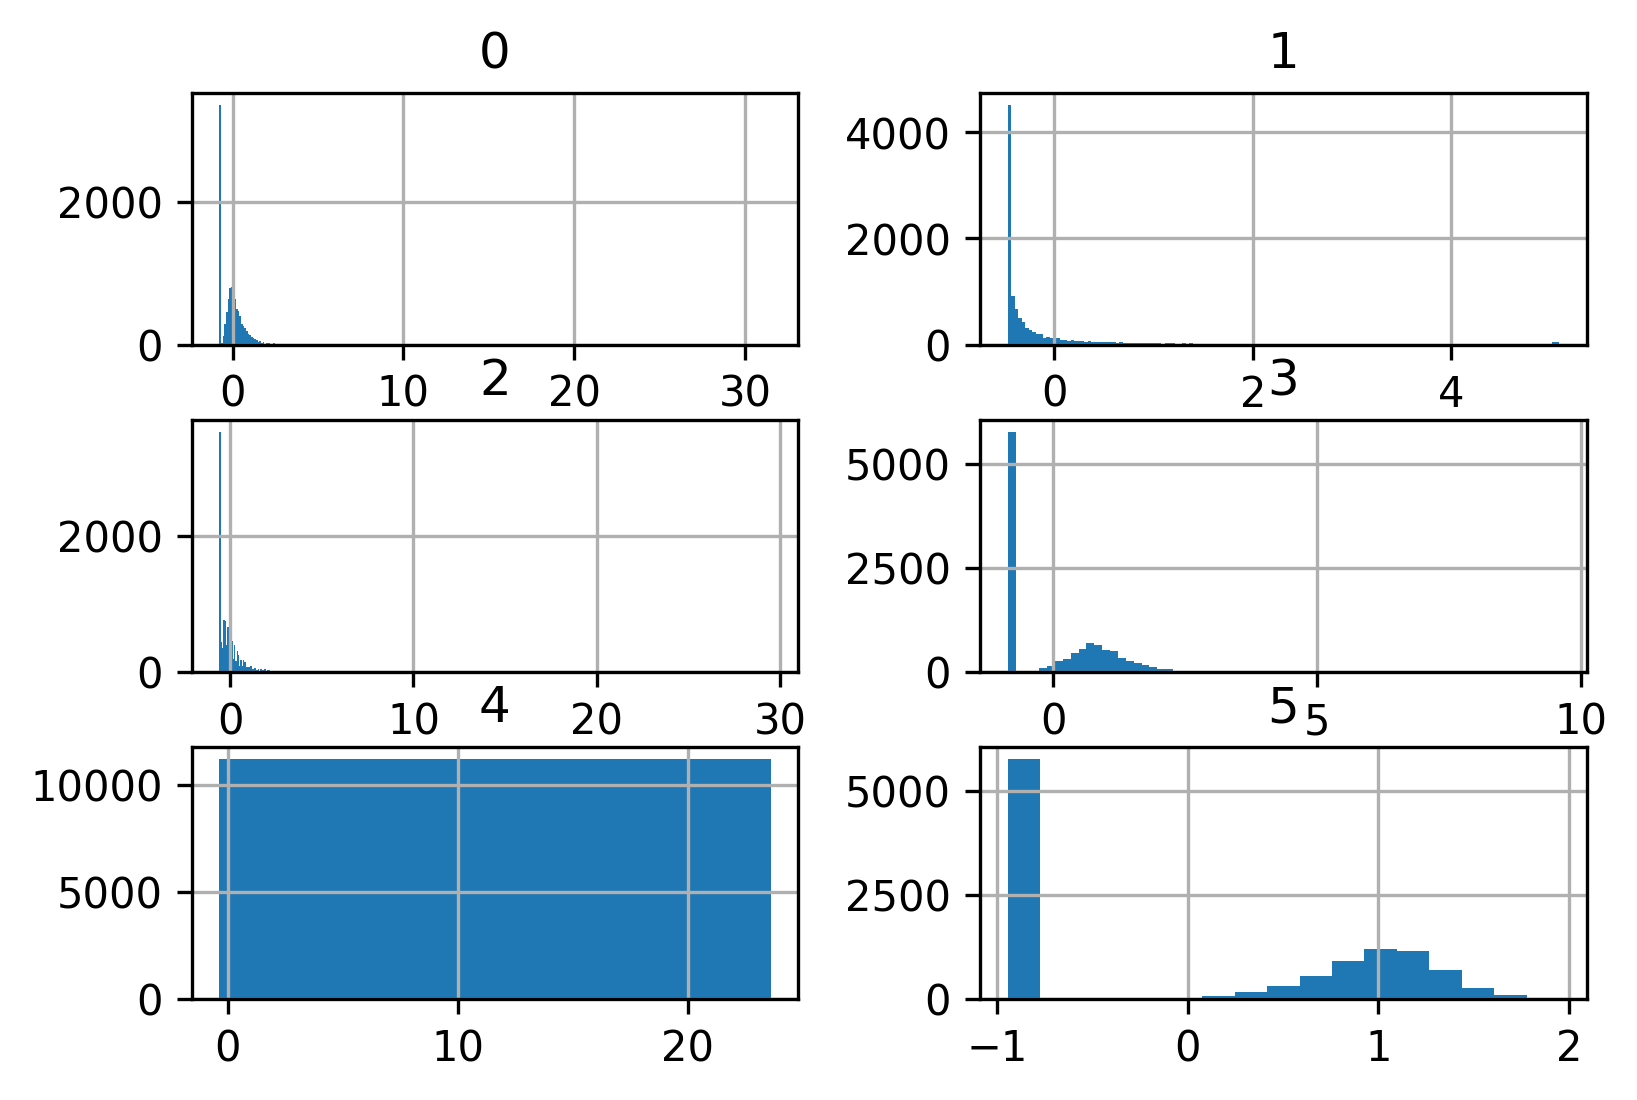

In [9]:
df.hist(bins='auto')

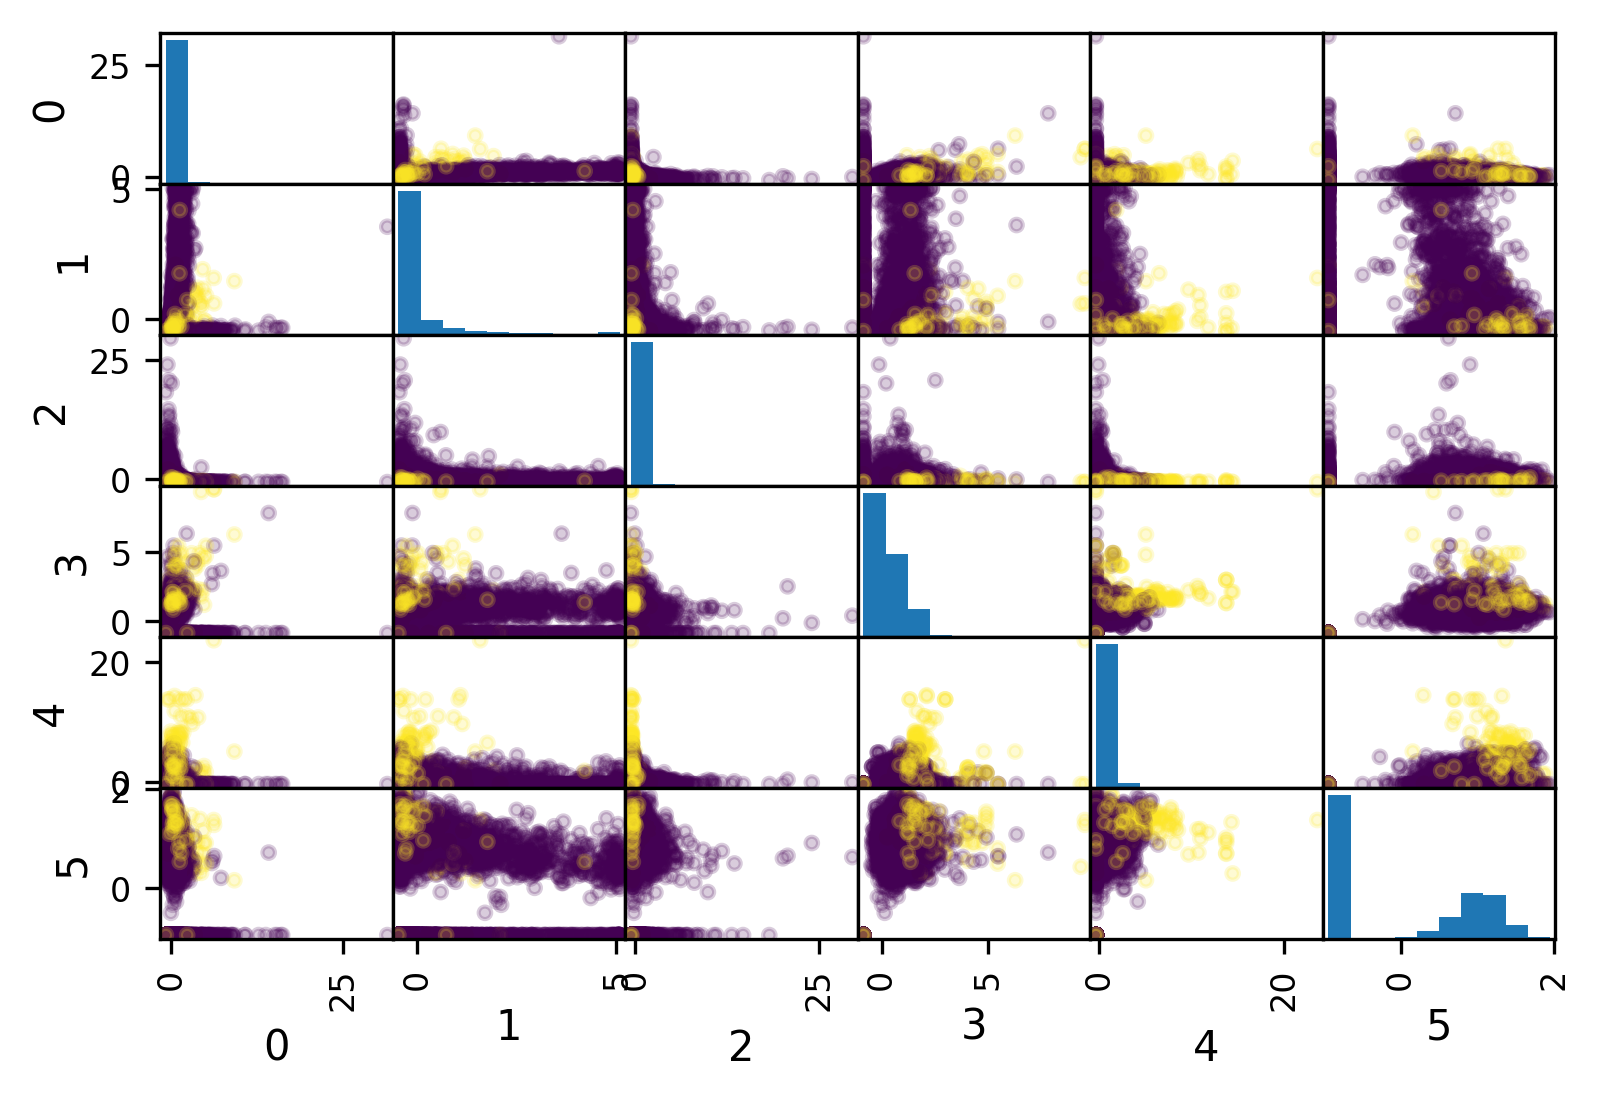

In [10]:
pd.scatter_matrix(df, c=y, alpha=.2);

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

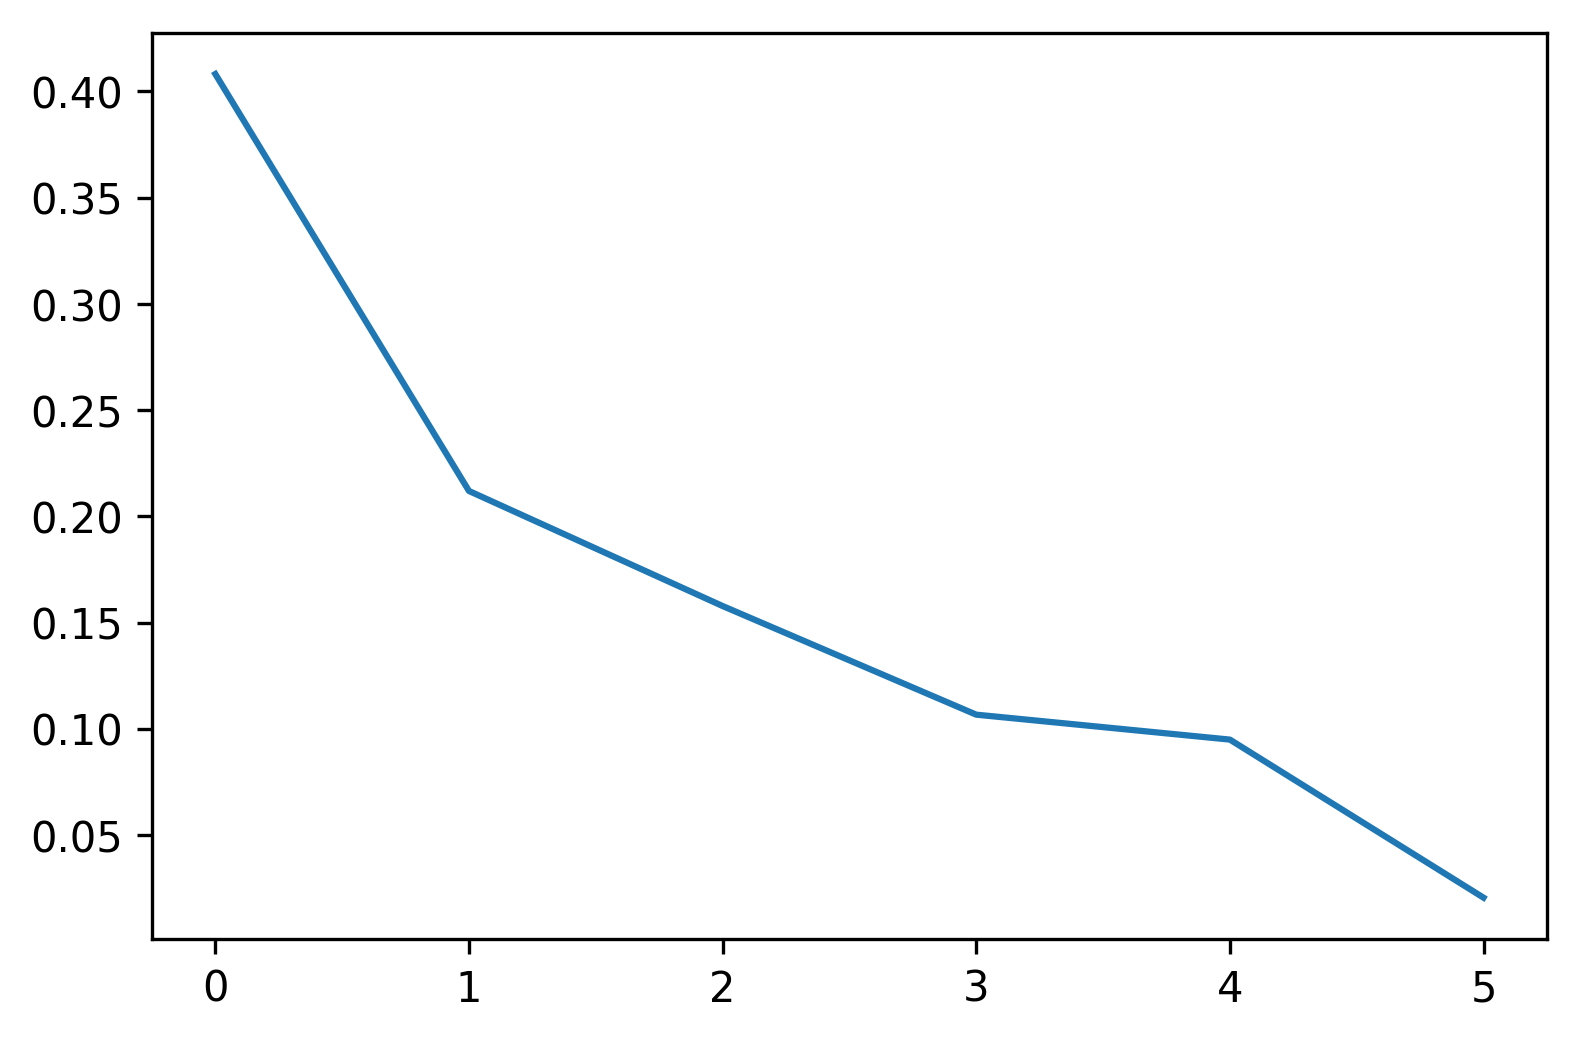

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)

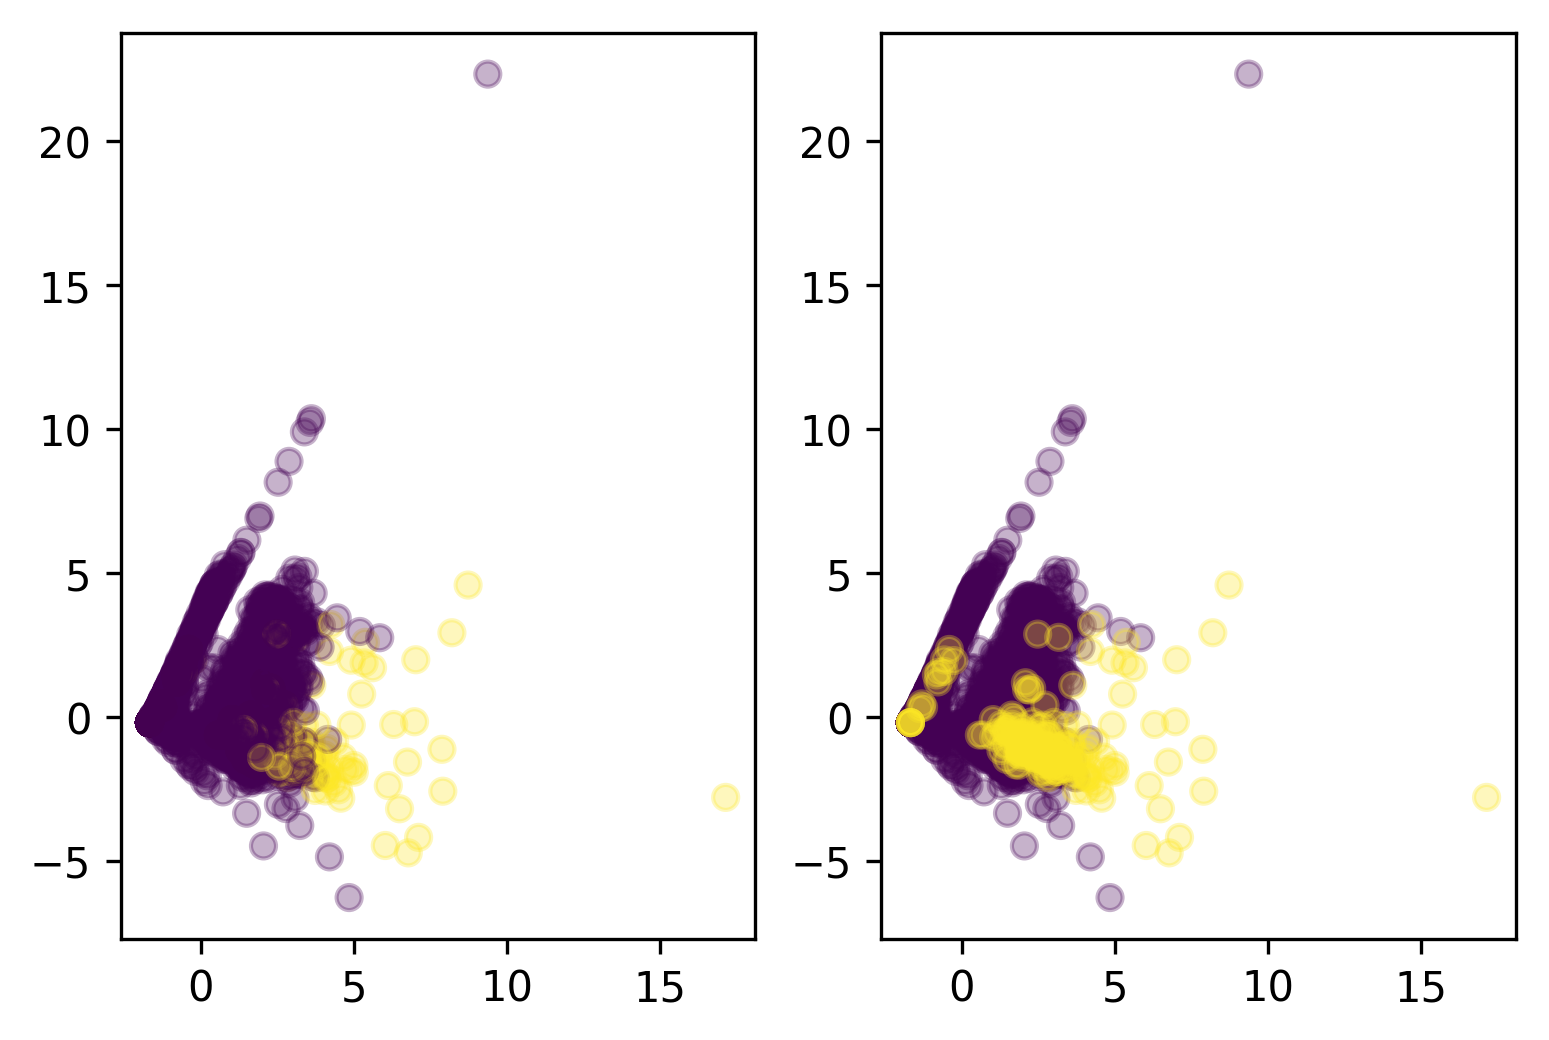

In [121]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train[:], alpha=.3)
axes[1].scatter(X_train_pca[sorting, 0], X_train_pca[sorting, 1], c=y_train[sorting], alpha=.3)

In [14]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler().fit(X_train)
X_train_scaled = rs.transform(X_train)

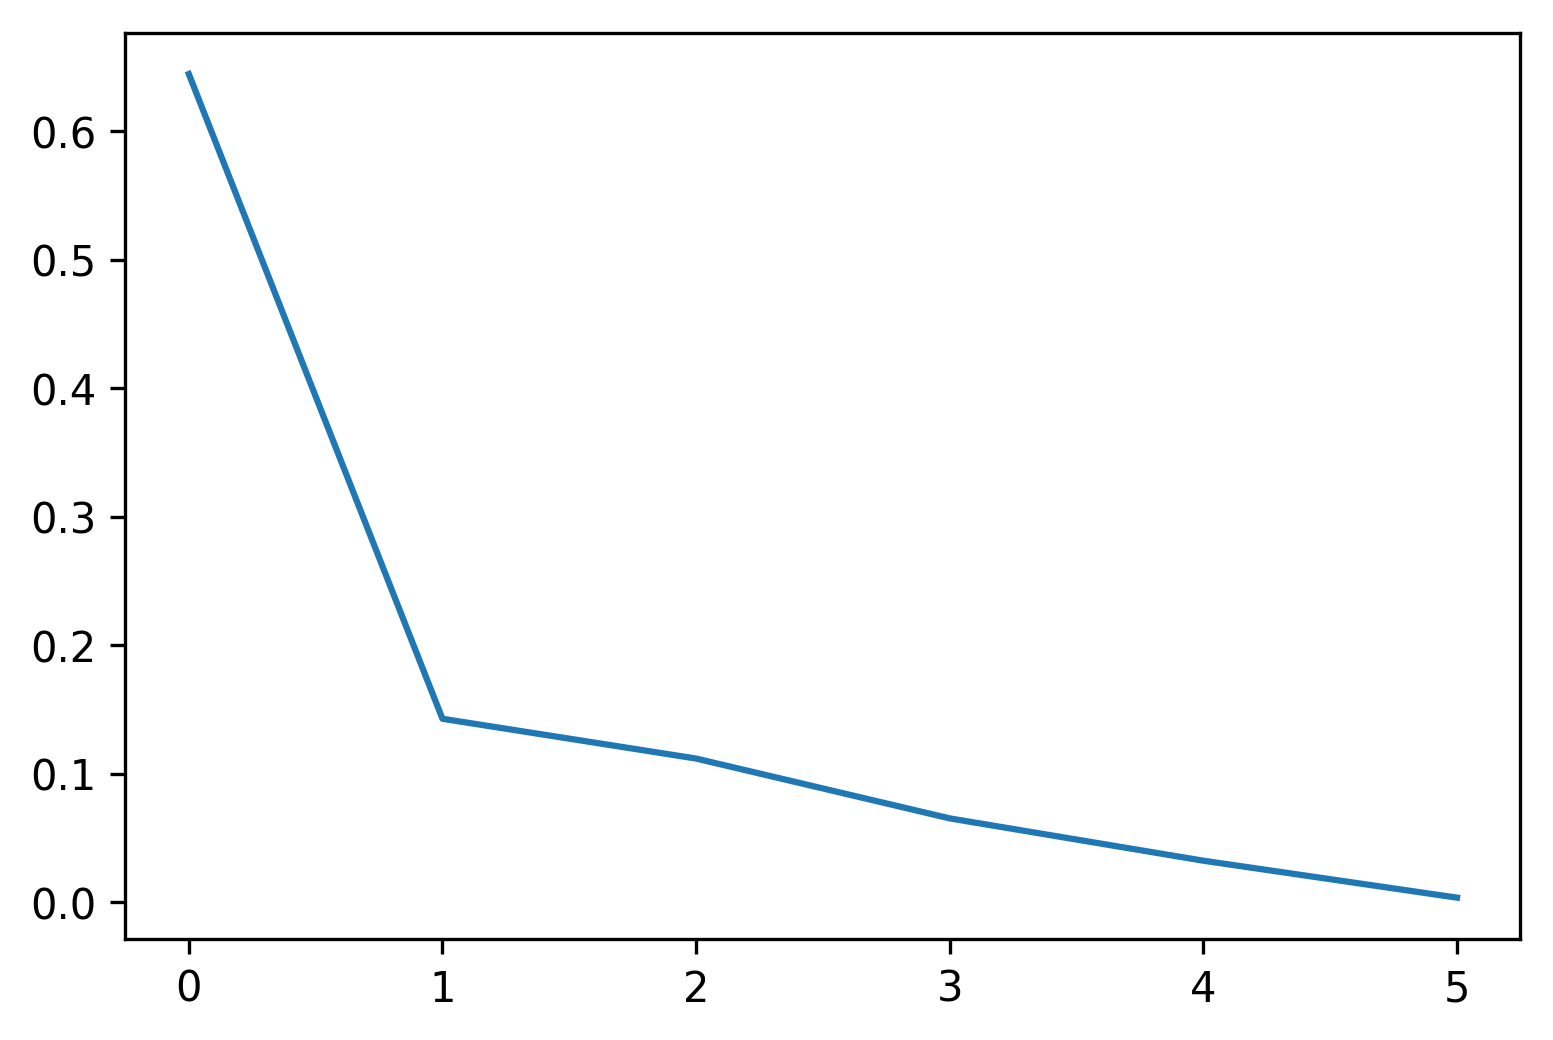

In [15]:
pca_scaled = PCA()
X_train_pca_scaled = pca_scaled.fit_transform(X_train_scaled)
plt.plot(pca_scaled.explained_variance_ratio_)

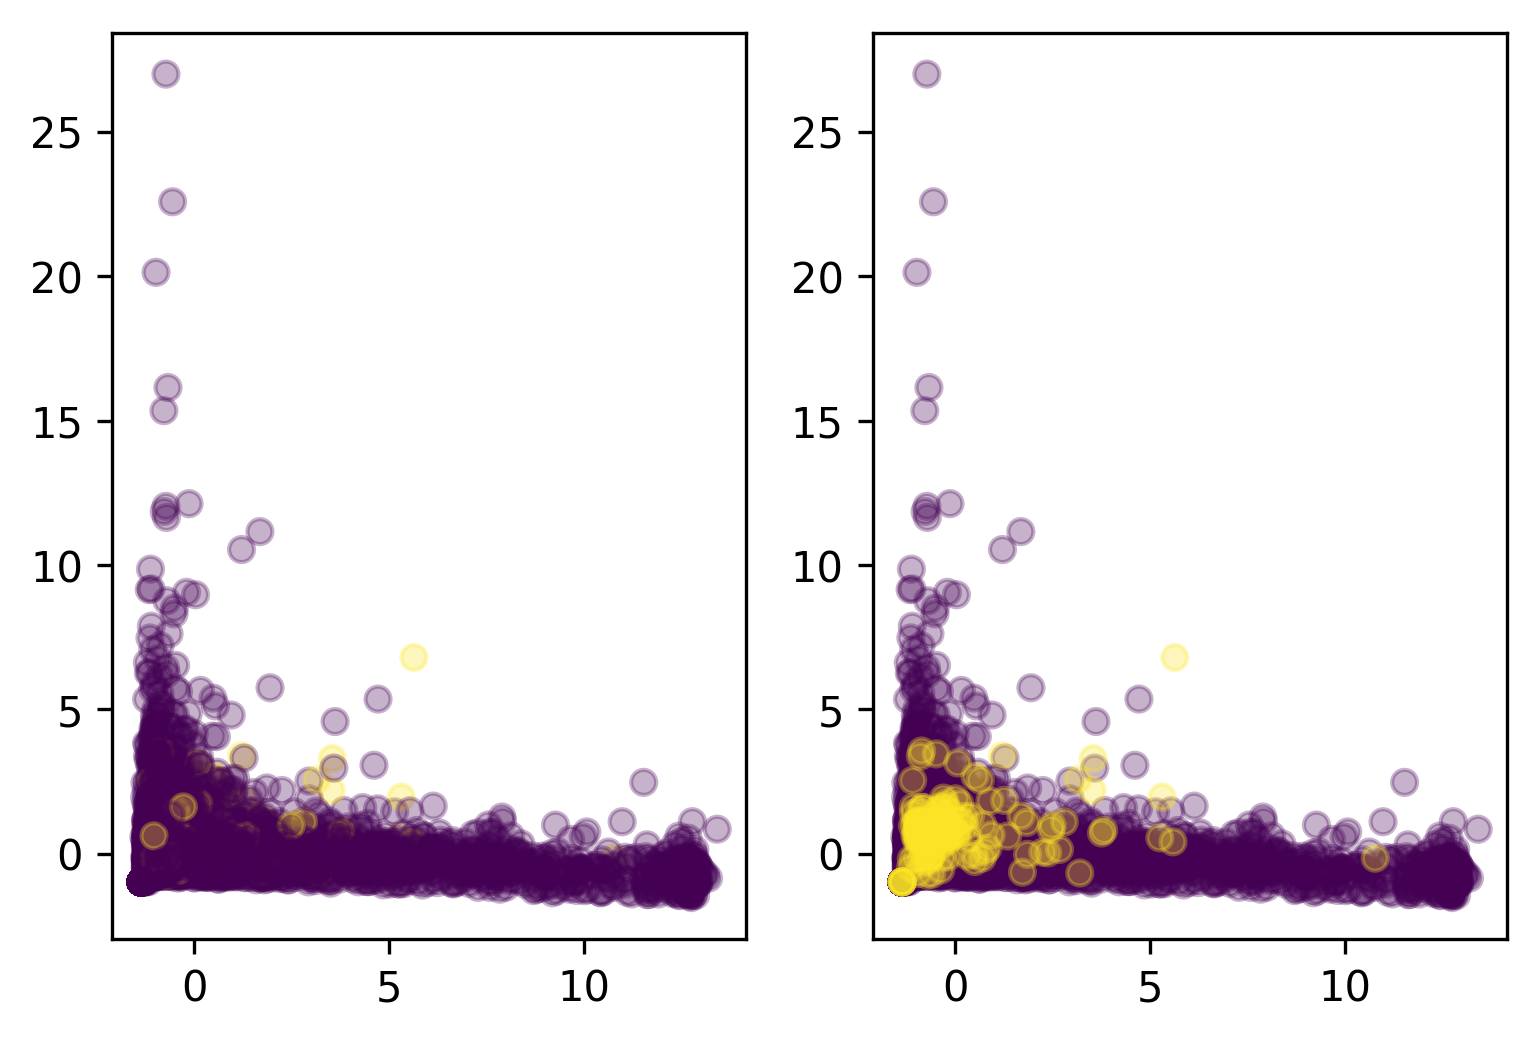

In [122]:
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=y_train[:], alpha=.3)
axes[1].scatter(X_train_pca_scaled[sorting, 0], X_train_pca_scaled[sorting, 1], c=y_train[sorting], alpha=.3)

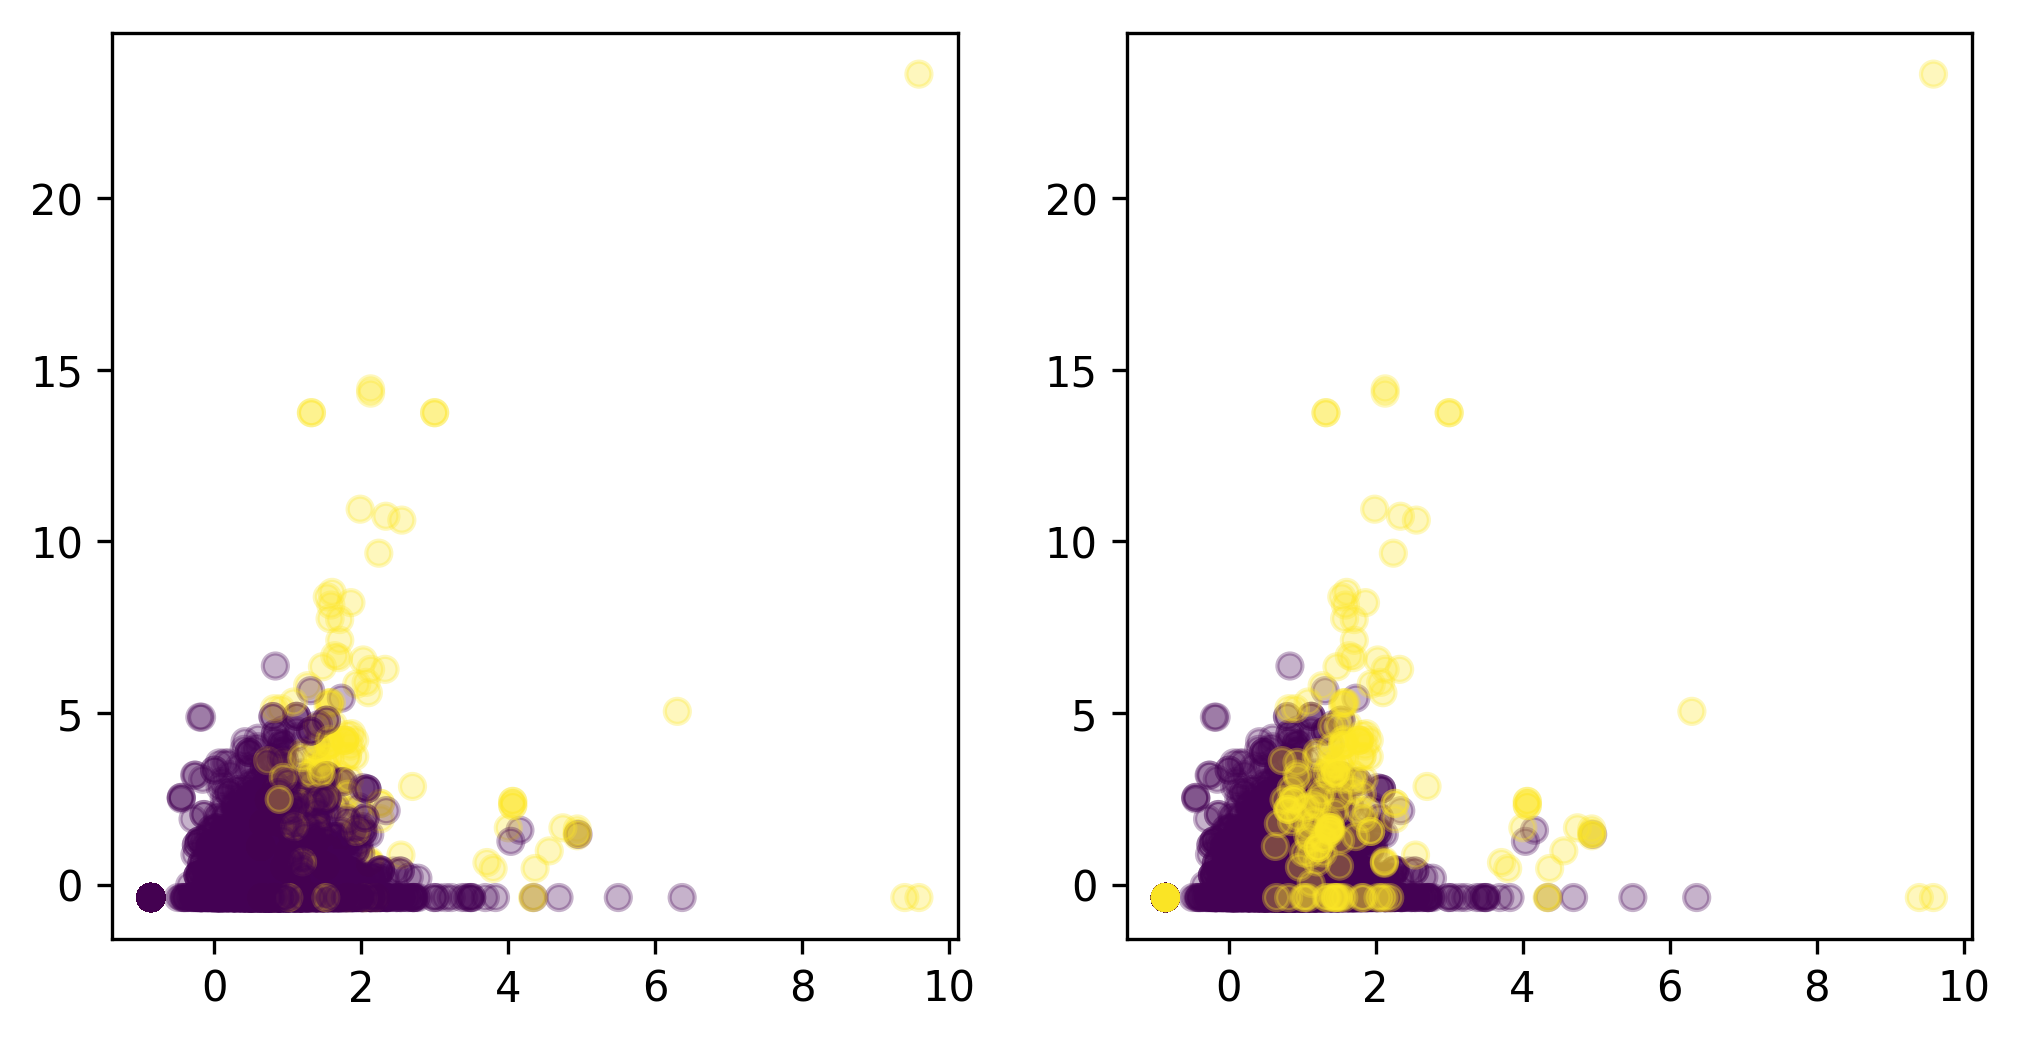

In [127]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train[:], alpha=.3)
axes[1].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)

In [18]:
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

0.919622716696


In [19]:
from sklearn.linear_model import LogisticRegressionCV
scores = cross_val_score(LogisticRegressionCV(scoring='roc_auc'), X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

0.918680168801


In [28]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [38]:
rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(8387, 6)
(390, 6)
[195 195]


In [47]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.916512922589


In [41]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(8387, 6)
(16384, 6)
[8192 8192]


In [67]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.917755942193


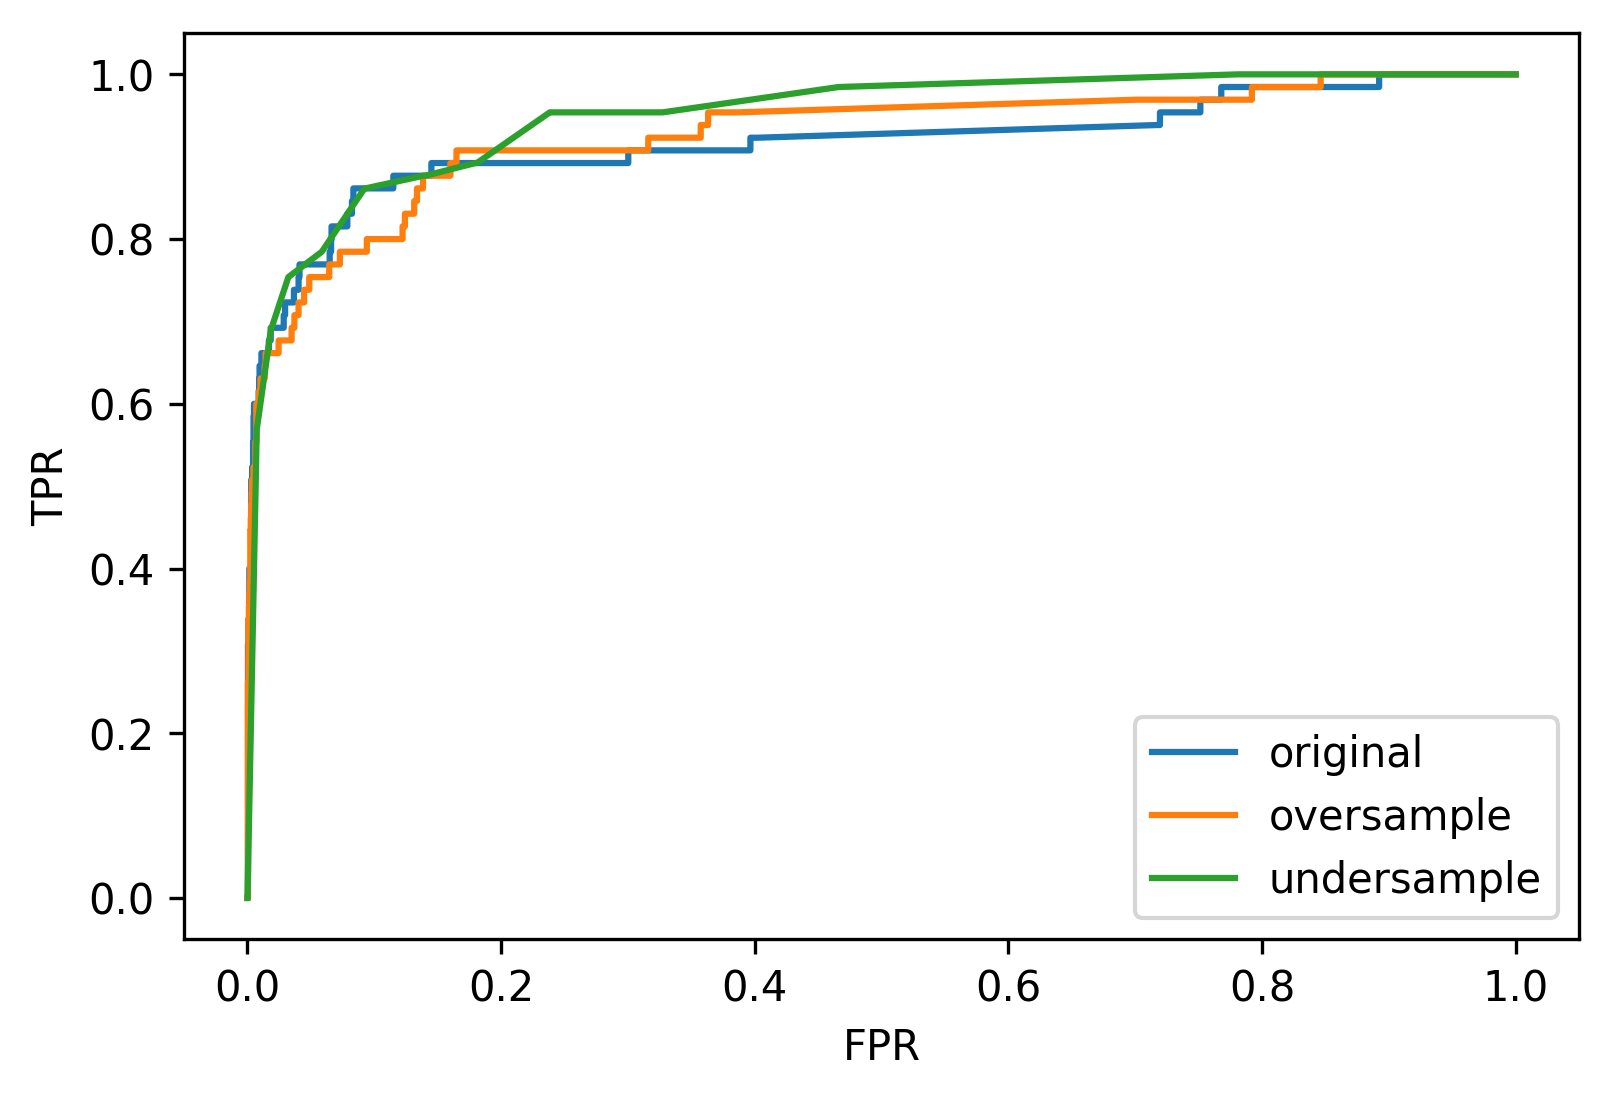

In [68]:
from sklearn.metrics import roc_curve
oversample_pipe.fit(X_train, y_train)
props_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, props_oversample)

undersample_pipe.fit(X_train, y_train)
props_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, props_undersample)

lr = LogisticRegression().fit(X_train, y_train)
props_original = lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, props_original)

plt.plot(fpr_org, tpr_org, label="original")
plt.plot(fpr_over, tpr_over, label="oversample")
plt.plot(fpr_under, tpr_under, label="undersample")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")

In [64]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_val_score(RandomForestClassifier(n_estimators=100), X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.94143939841


In [65]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.944496565836


In [69]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.891189066122


# Class Weights

In [71]:
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

0.917567920152


In [75]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_val_score(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.91679851501


# Resampled Ensembles

In [81]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
def make_resample_tree(random_state=0):
    tree = make_imb_pipeline(RandomUnderSampler(random_state=random_state, replacement=True),
                             DecisionTreeClassifier(max_features='auto', random_state=random_state))
    return "tree_i".format(random_state), tree
classifiers = [make_resample_tree(i) for i in range(100)]
resampled_rf = VotingClassifier(classifiers, voting='soft')

In [83]:
scores = cross_val_score(resampled_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.960342658946


In [91]:
from sklearn.base import clone

def make_resampled_ensemble(estimator, n_estimators=100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting="soft")

In [93]:
resampled_tree_test = make_resampled_ensemble(DecisionTreeClassifier(max_features='auto'))

scores = cross_val_score(resampled_tree_test, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.960342658946


In [96]:
resampled_lr = make_resampled_ensemble(LogisticRegression())

scores = cross_val_score(resampled_lr, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.91984996634


# Edited Nearest Neighbors

In [130]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_sample(X_train, y_train)

enn_mode = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)
X_train_enn_mode, y_train_enn_mode = enn_mode.fit_sample(X_train, y_train)

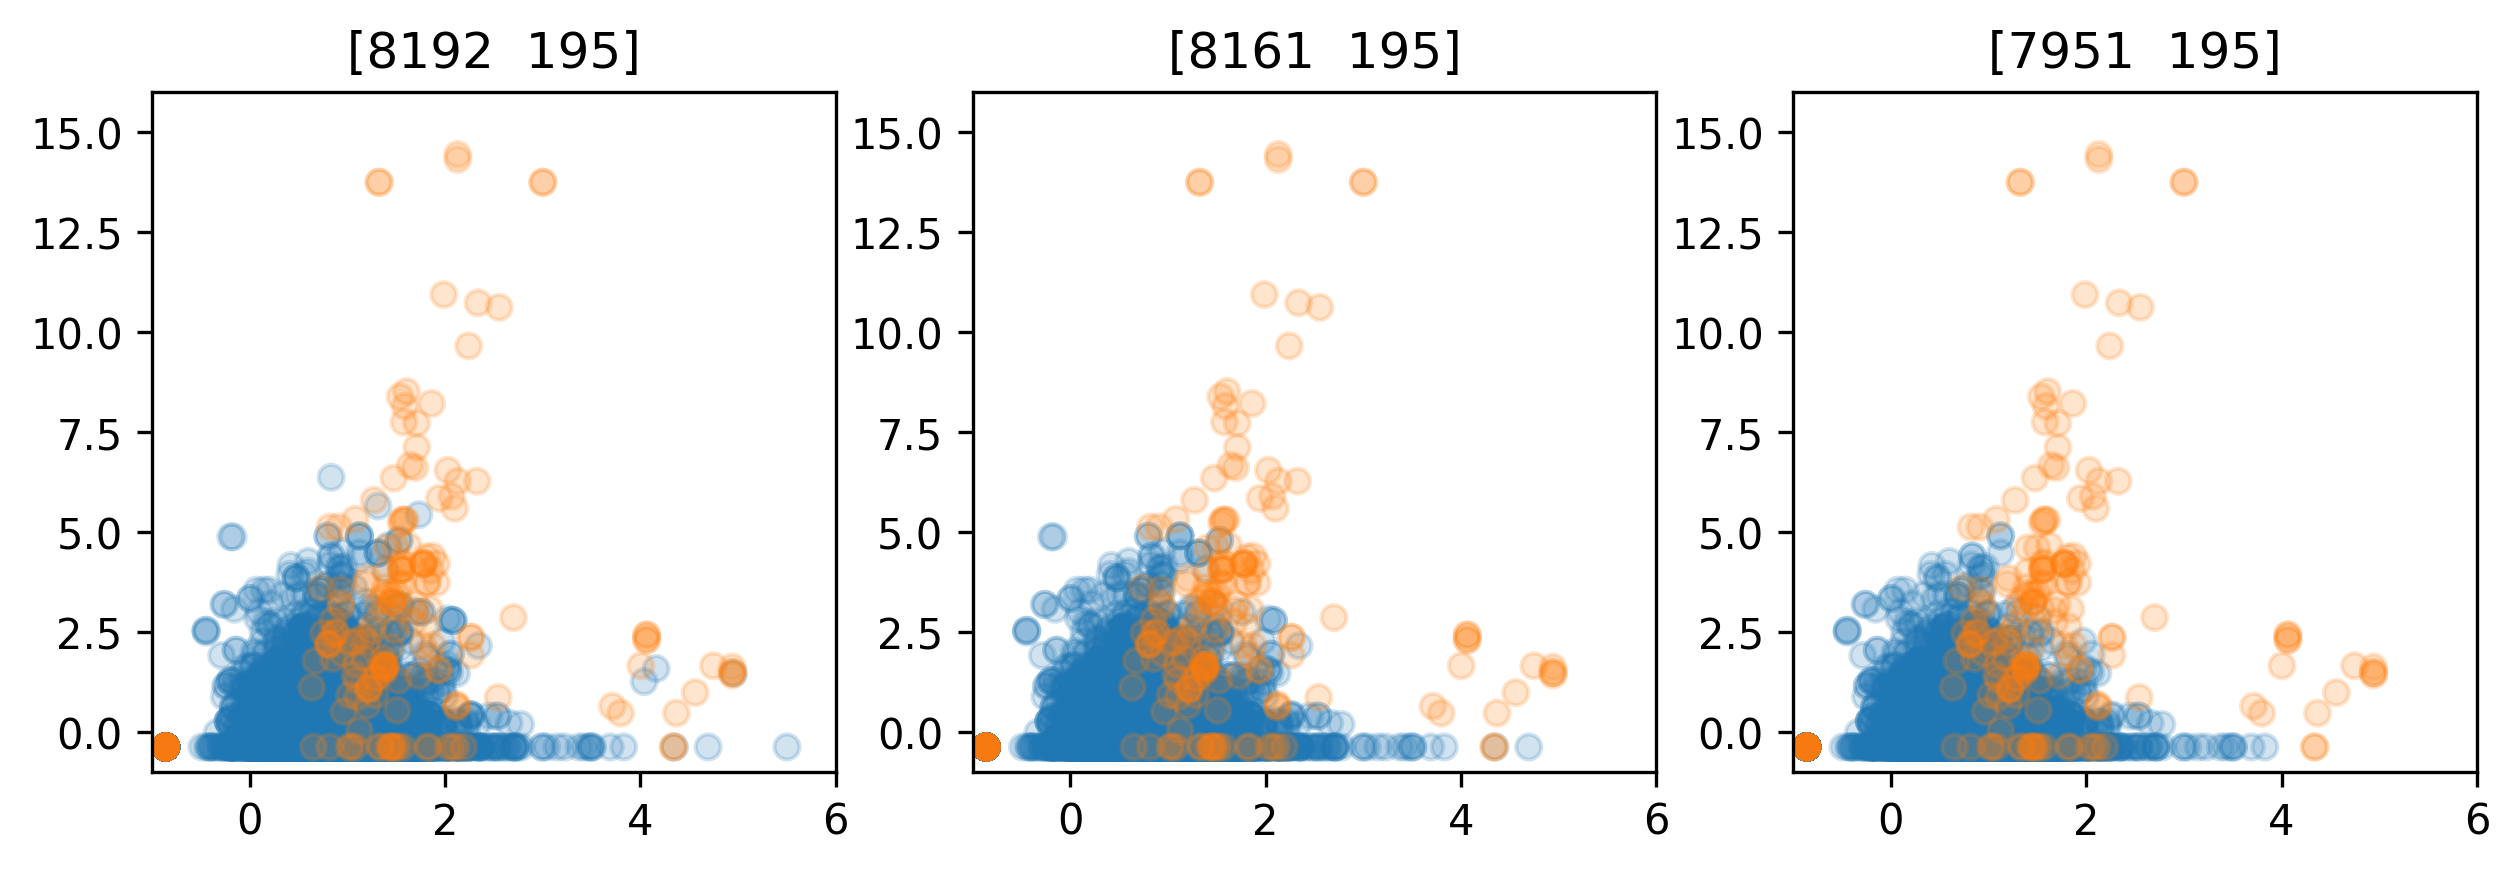

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
datasets = [(X_train, y_train), (X_train_enn_mode, y_train_enn_mode), (X_train_enn, y_train_enn)]
for ax, (X_, y_) in zip(axes, datasets):
    # make sure we plot the orange over the blue
    sorting = np.argsort(y_)
    ax.scatter(X_[sorting, 3], X_[sorting, 4], c=plt.cm.Vega10(y_[sorting]), alpha=.2)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, 16)
    ax.set_title(np.bincount(y_))

In [132]:
enn_pipe = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5), LogisticRegression())
scores = cross_val_score(enn_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.920155354576


In [ ]:
enn_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(enn_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

In [187]:
from sklearn.model_selection import GridSearchCV
param_grid = {'editednearestneighbours__n_neighbors': [3, 5, 9, 15, 31, 51], 'editednearestneighbours__kind_sel': ['mode', 'all']}
search = GridSearchCV(enn_pipe, param_grid, cv=10, scoring="roc_auc")
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('editednearestneighbours', EditedNearestNeighbours(kind_sel='all', n_jobs=1, n_neighbors=5,
            random_state=None, return_indices=False, size_ngh=None)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'editednearestneighbours__n_neighbors': [3, 5, 9, 15, 31, 51], 'editednearestneighbours__kind_sel': ['mode', 'all']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [190]:
results = pd.DataFrame(search.cv_results_)
res_pivot = results.pivot_table(values=['mean_test_score', 'mean_train_score'],
                                columns="param_editednearestneighbours__kind_sel",
                                index="param_editednearestneighbours__n_neighbors")

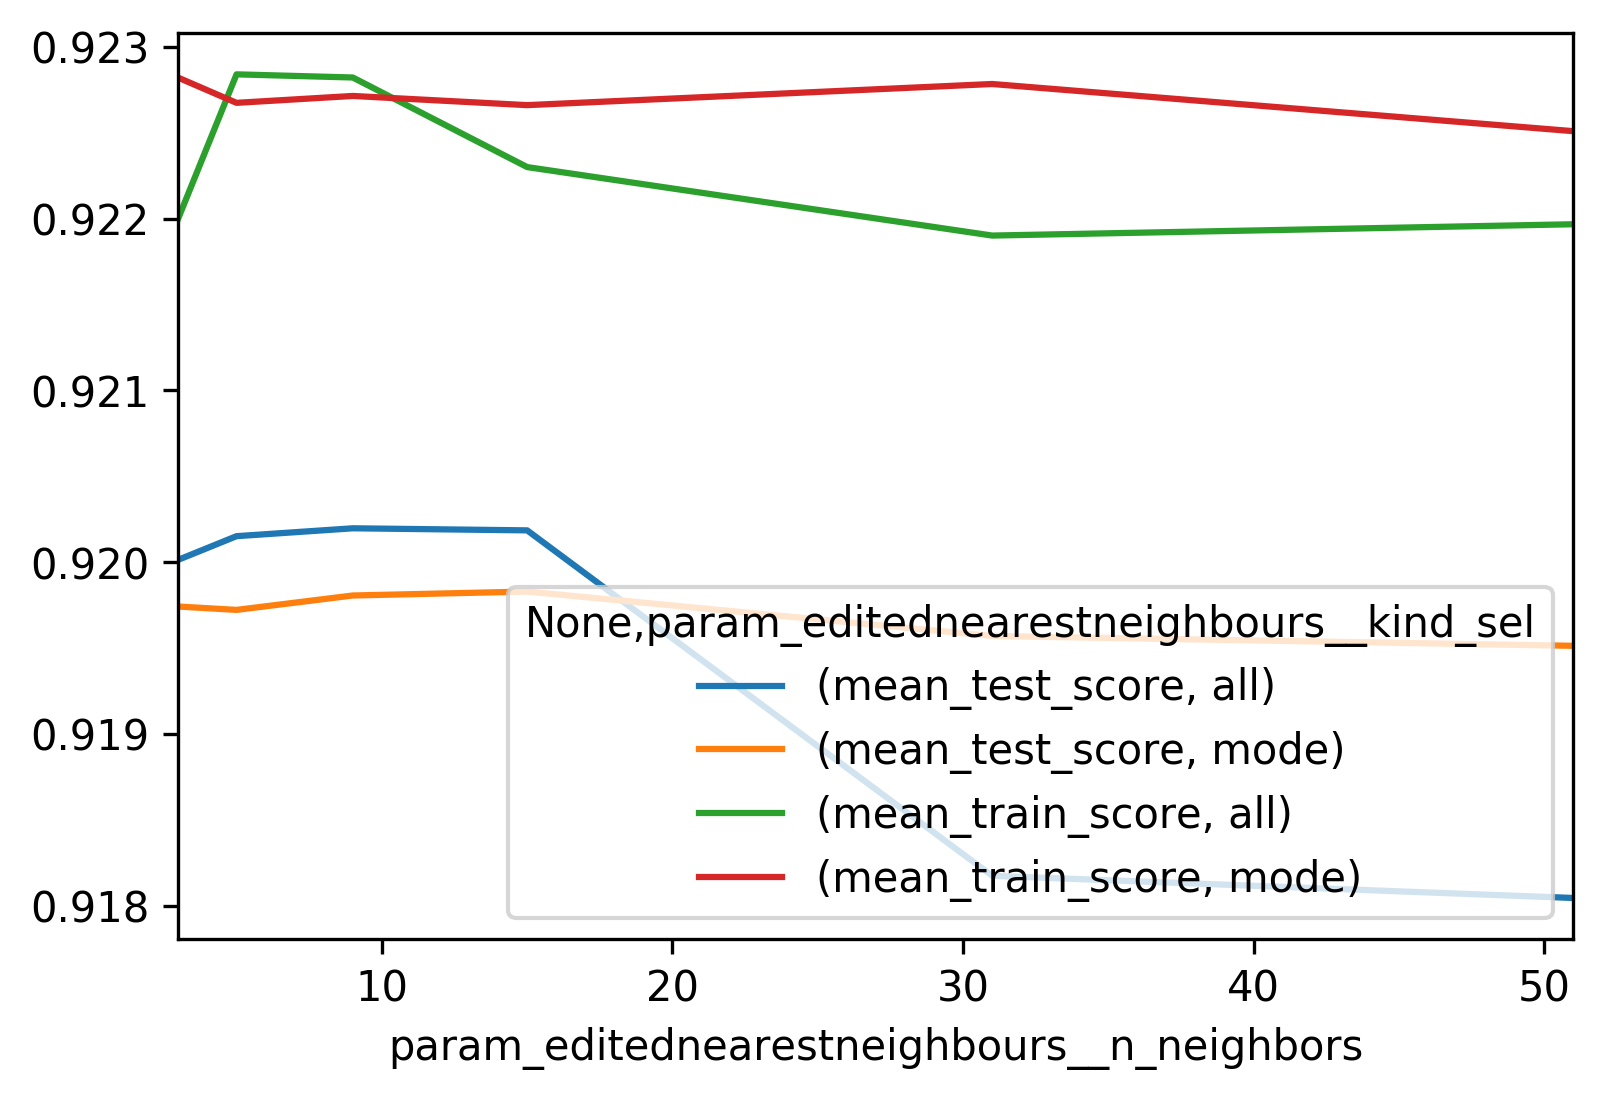

In [191]:
res_pivot.plot()

In [192]:
from sklearn.model_selection import GridSearchCV
param_grid = {'editednearestneighbours__n_neighbors': [3, 5, 9, 15, 31, 51], 'editednearestneighbours__kind_sel': ['mode', 'all']}
search = GridSearchCV(enn_pipe_rf, param_grid, cv=10, scoring="roc_auc")
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('editednearestneighbours', EditedNearestNeighbours(kind_sel='all', n_jobs=1, n_neighbors=5,
            random_state=None, return_indices=False, size_ngh=None)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None,...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'editednearestneighbours__n_neighbors': [3, 5, 9, 15, 31, 51], 'editednearestneighbours__kind_sel': ['mode', 'all']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [193]:
results = pd.DataFrame(search.cv_results_)
res_pivot = results.pivot_table(values=['mean_test_score', 'mean_train_score'],
                                columns="param_editednearestneighbours__kind_sel",
                                index="param_editednearestneighbours__n_neighbors")

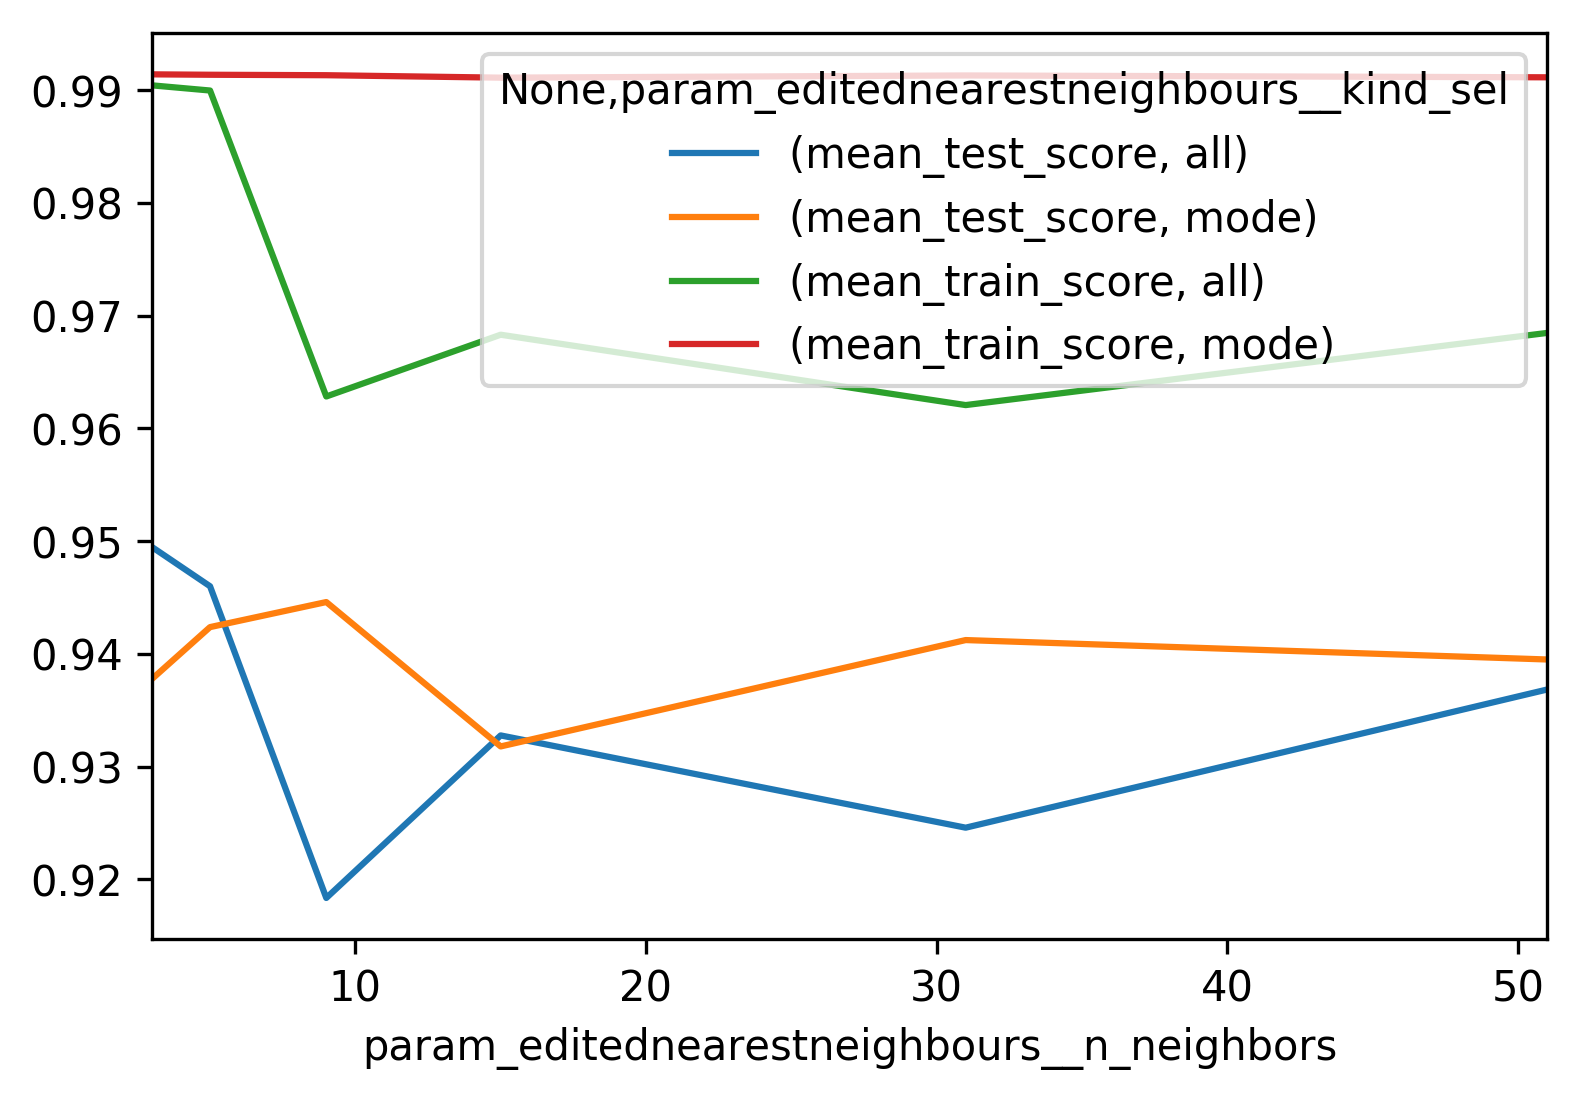

In [194]:
res_pivot.plot()

In [196]:
search.best_score_

0.94949041879522034

# Tomek

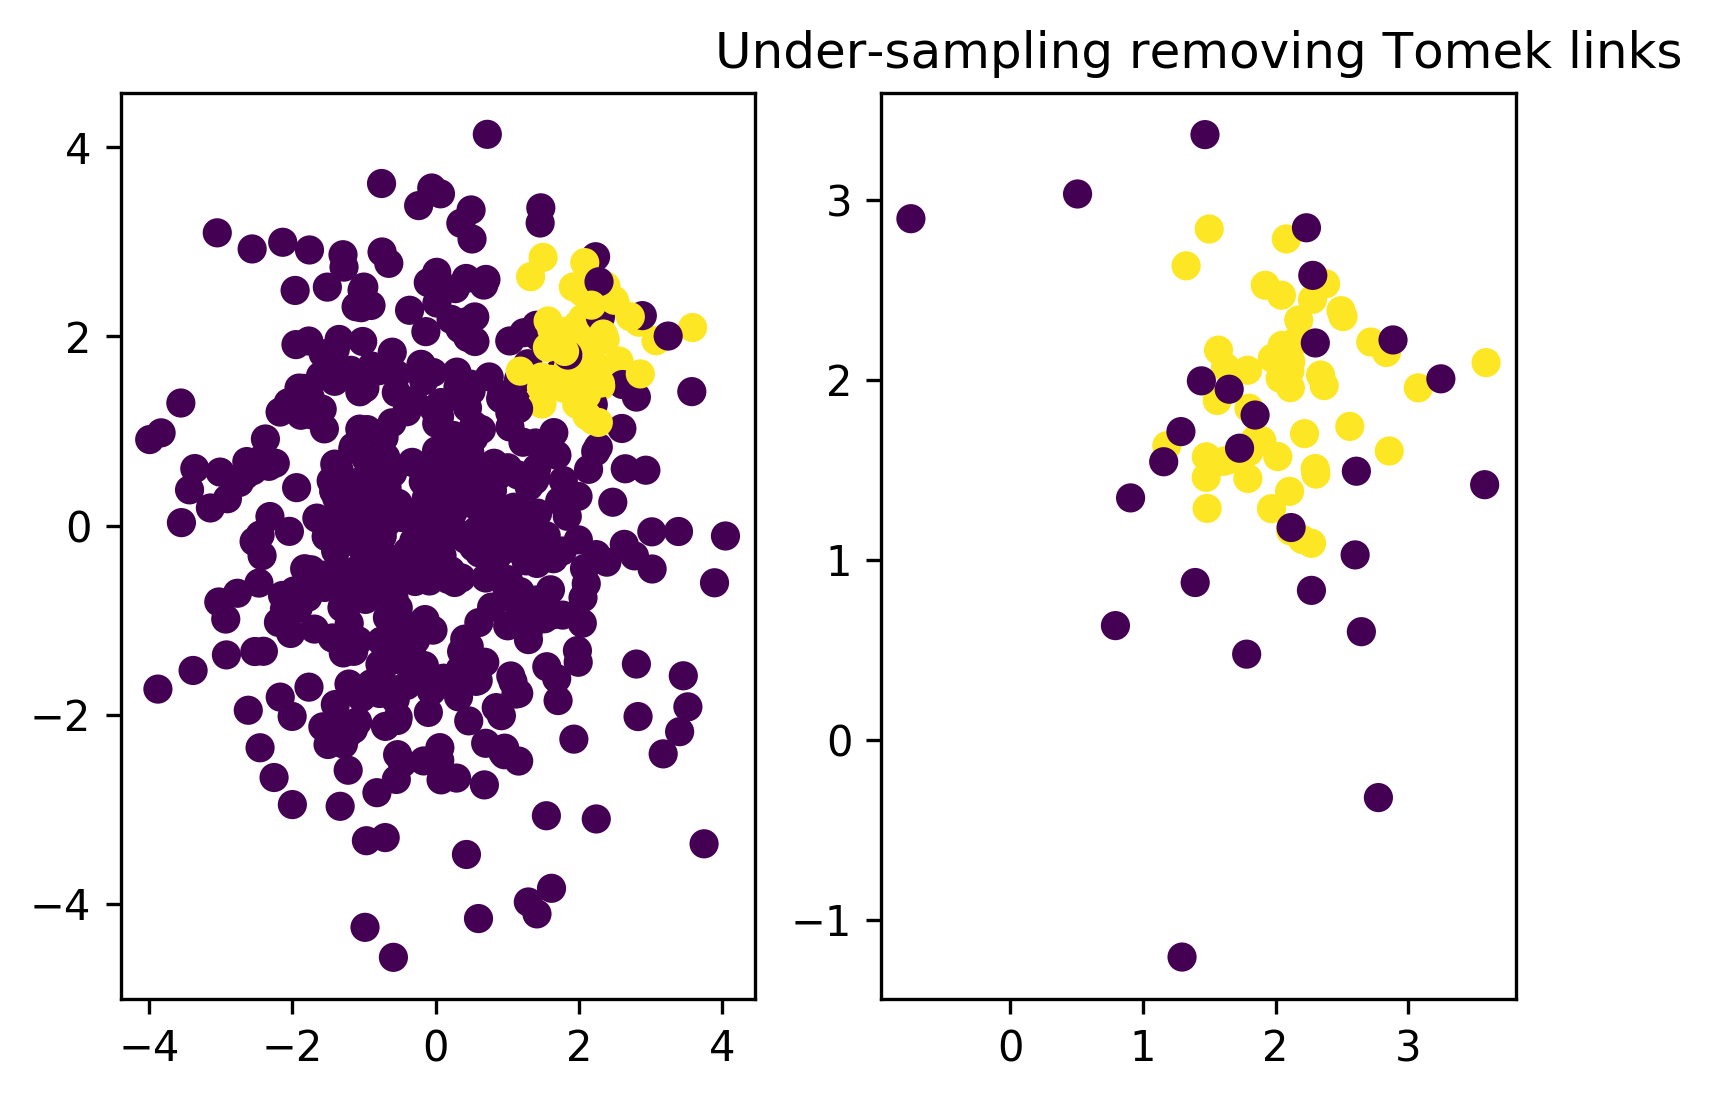

In [265]:
"""
===========
Tomek links
===========
An illustration of the Tomek links method.
"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

from imblearn.under_sampling import TomekLinks, CondensedNearestNeighbour

rng = np.random.RandomState(0)
n_samples_1 = 500
n_samples_2 = 50
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn, y_syn = shuffle(X_syn, y_syn)
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)


# remove Tomek links
tl = TomekLinks(return_indices=True)
tl = CondensedNearestNeighbour(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X_syn, y_syn)

fig, axes = plt.subplots(1, 2)
plt.title('Under-sampling removing Tomek links')
axes[0].scatter(X_syn[:, 0], X_syn[:, 1], c=y_syn)
axes[1].scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled)

In [261]:
idx_resampled

array([ 10,  14,  17,  19,  71,  88,  98, 115, 124, 127, 132, 155, 186,
       193, 217, 221, 242, 245, 275, 284, 287, 291, 309, 316, 326, 330,
       338, 351, 376, 380, 385, 392, 393, 395, 412, 430, 441, 447, 449,
       455, 460, 476, 478, 481, 490, 495, 503, 514, 548, 549, 230,   0,
         2,   7,  18,  26,  27,  28,  33,  40,  49,  64,  73,  78,  84,
       113, 118, 122, 216, 308, 314, 358, 400, 445, 463, 469, 479])

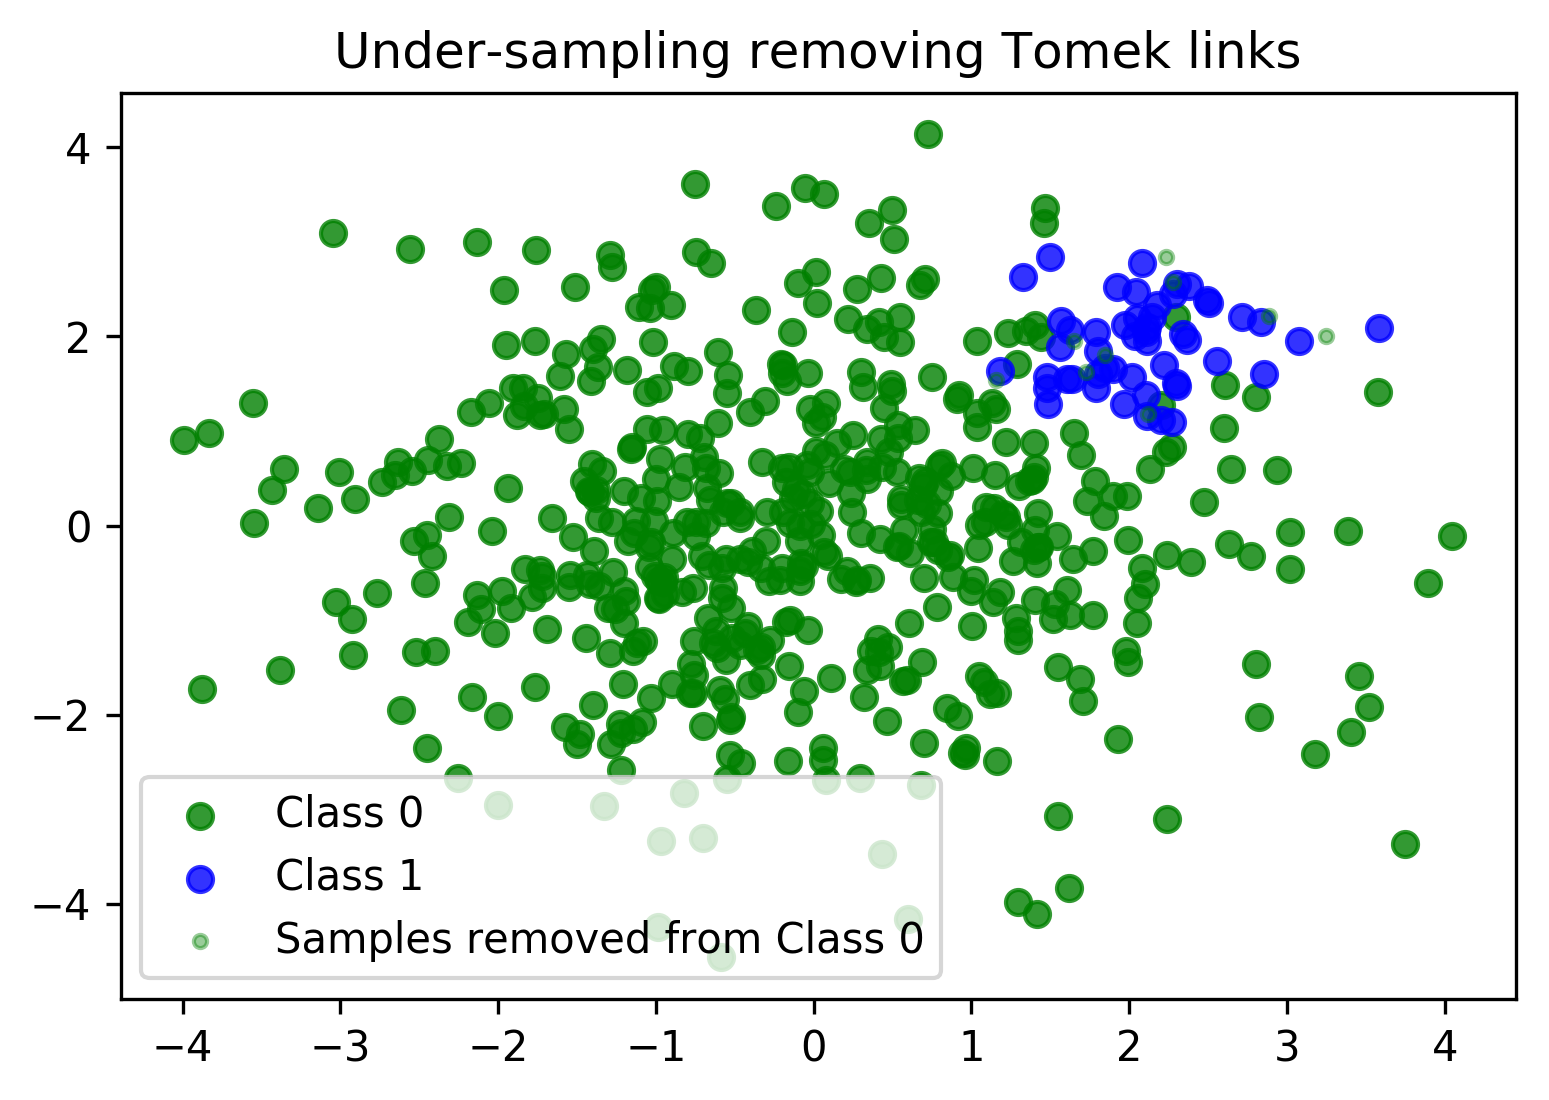

In [288]:
from imblearn.under_sampling import TomekLinks, CondensedNearestNeighbour

rng = np.random.RandomState(0)
n_samples_1 = 500
n_samples_2 = 50
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn, y_syn = shuffle(X_syn, y_syn)
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)


# remove Tomek links
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X_syn, y_syn)

def plot_resampled(X_org, y_org, X_res, y_res, idx, ax=None):
    if ax is None:
        ax = plt.gca()
    idx_samples_removed = np.setdiff1d(np.arange(X_org.shape[0]),
                                       idx)
    idx_class_0 = y_res == 0
    ax.scatter(X_res[idx_class_0, 0], X_res[idx_class_0, 1],
                c='g', alpha=.8, label='Class 0')
    ax.scatter(X_res[~idx_class_0, 0], X_res[~idx_class_0, 1],
                c='b', alpha=.8, label='Class 1')
    ax.scatter(X_org[idx_samples_removed, 0], X_org[idx_samples_removed, 1],
                c='g', alpha=.4, s=10, label='Samples removed from Class 0')
    ax.legend()

plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled)
plt.title('Under-sampling removing Tomek links')


plt.show()

In [290]:
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X_syn, y_syn)

np.bincount(y_resampled)

array([491,  50])

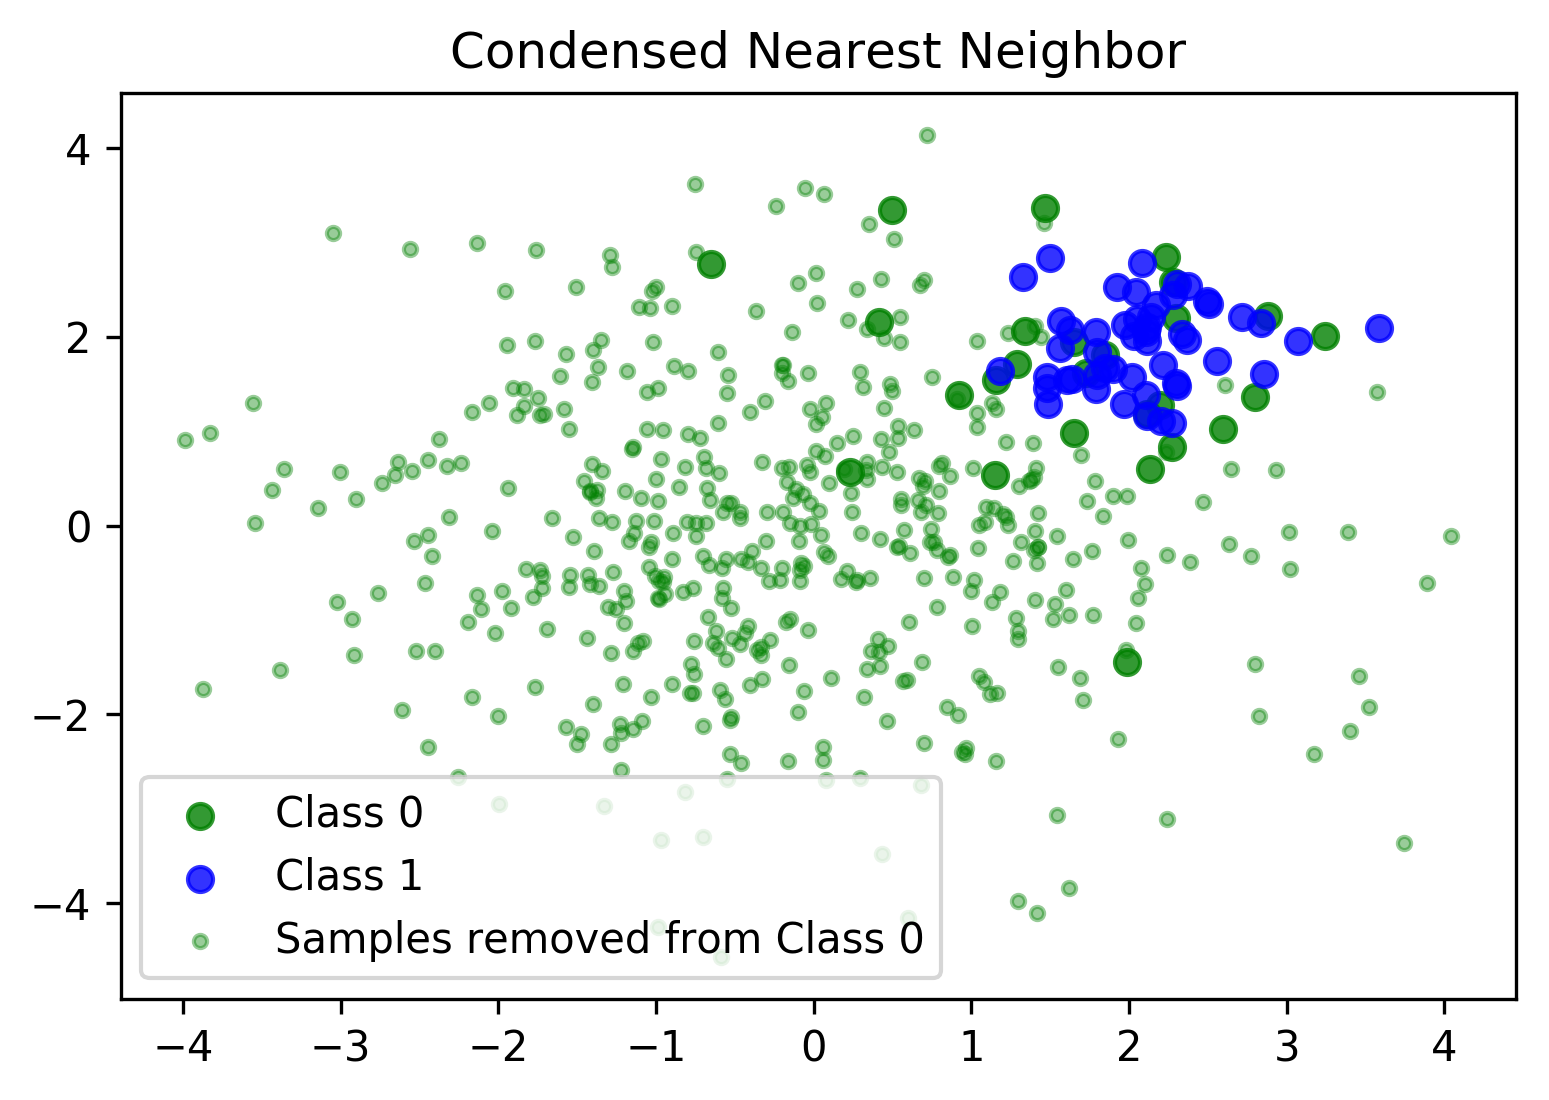

In [281]:
cnn = CondensedNearestNeighbour(return_indices=True)
X_resampled, y_resampled, idx_resampled = cnn.fit_sample(X_syn, y_syn)
plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled)
plt.title("Condensed Nearest Neighbor")

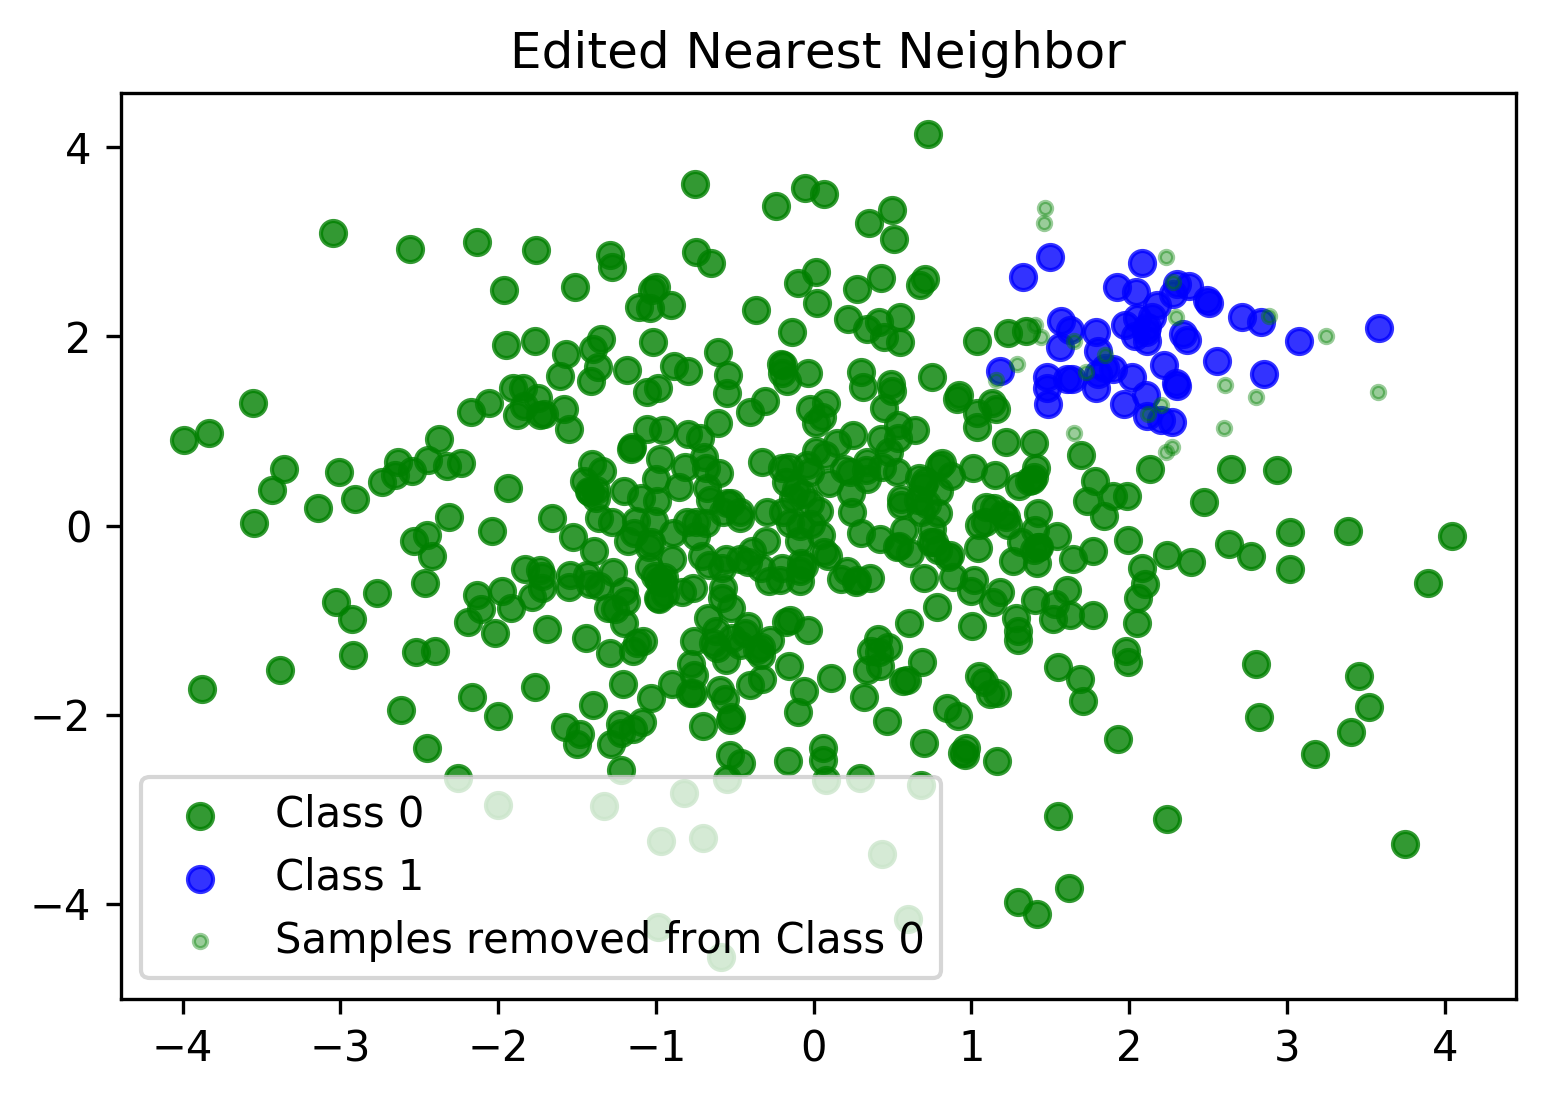

In [279]:
enn = EditedNearestNeighbours(return_indices=True)
X_resampled, y_resampled, idx_resampled = enn.fit_sample(X_syn, y_syn)
plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled)
plt.title("Edited Nearest Neighbor")

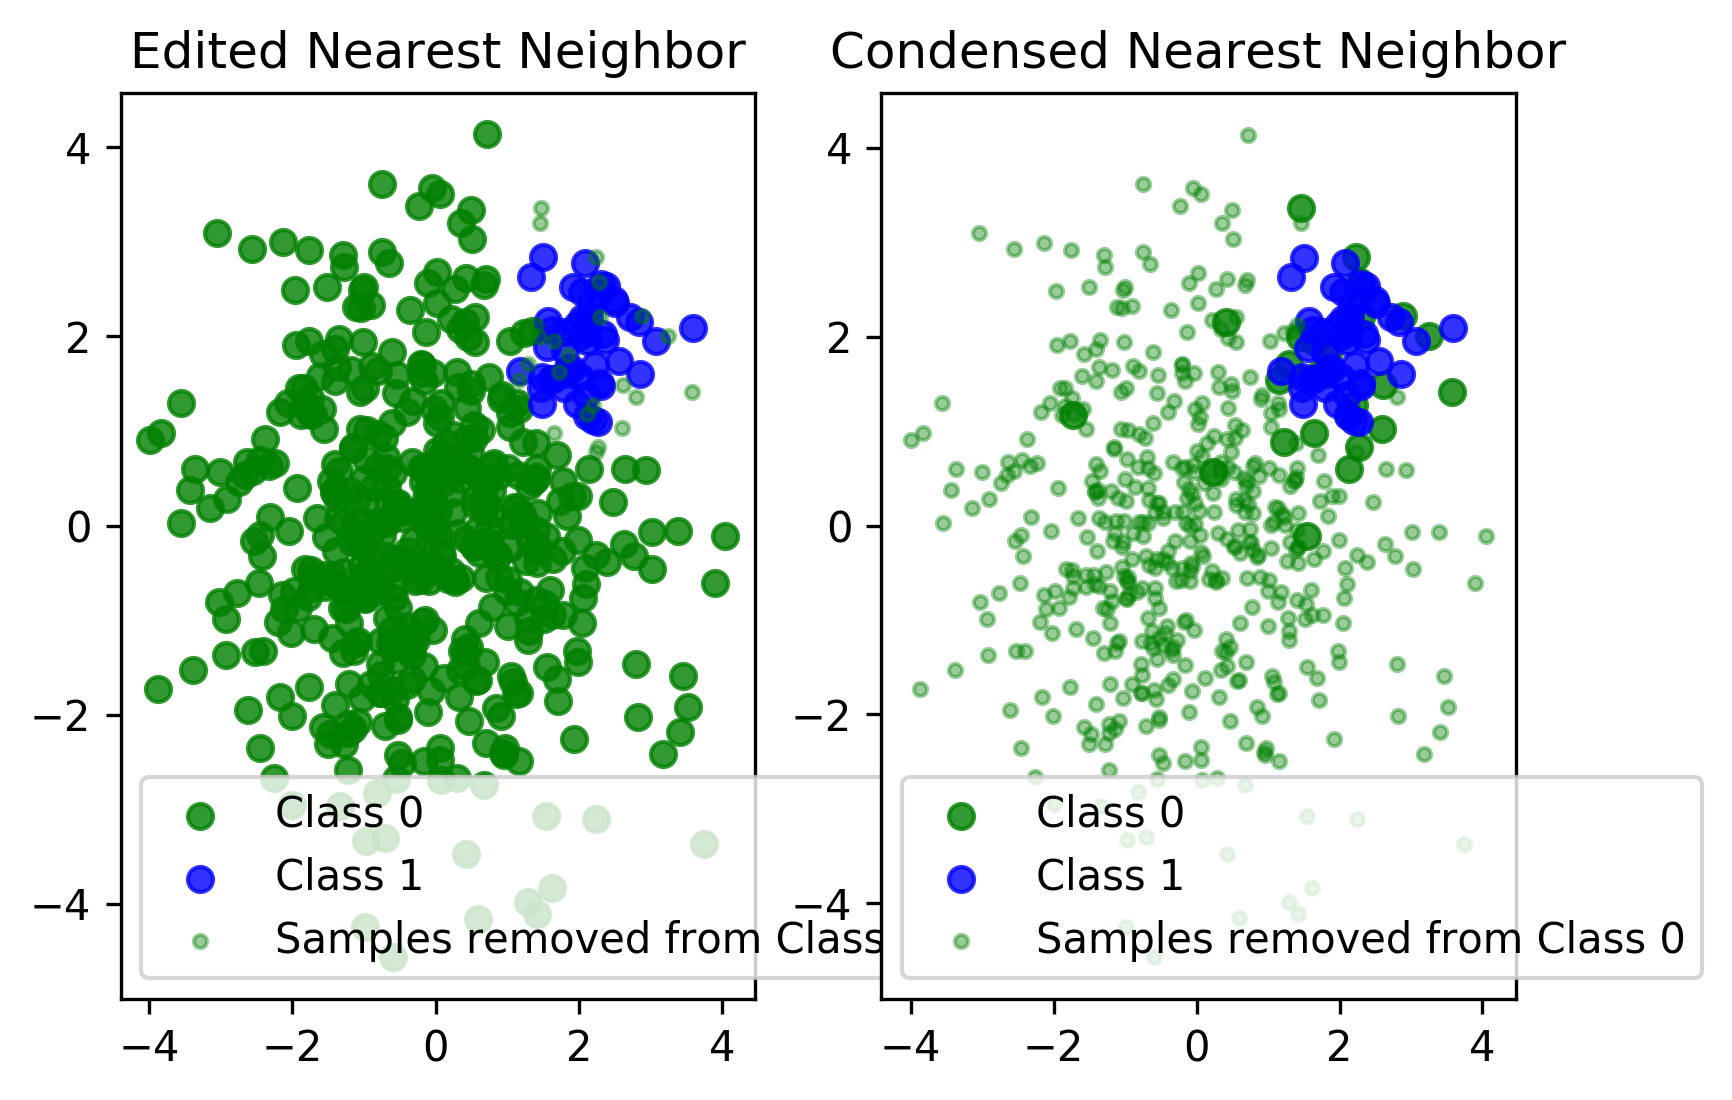

In [287]:
fig, ax = plt.subplots(1, 2)
enn = EditedNearestNeighbours(return_indices=True)
X_resampled, y_resampled, idx_resampled = enn.fit_sample(X_syn, y_syn)
plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled, ax=ax[0])
ax[0].set_title("Edited Nearest Neighbor")
X_resampled, y_resampled, idx_resampled = CondensedNearestNeighbour(return_indices=True).fit_sample(X_syn, y_syn)
plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled, ax=ax[1])
ax[1].set_title("Condensed Nearest Neighbor")

In [143]:
from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_sample(X_train, y_train)
print(X_train_tomek.shape)
print(np.bincount(y_train_tomek))

(8355, 6)
[8160  195]


In [145]:
tomek_pipe = make_imb_pipeline(TomekLinks(), LogisticRegression())
scores = cross_val_score(tomek_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.919743120896


# SMOTE

In [221]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
print(X_train_smote.shape)
print(np.bincount(y_train_smote))

(16384, 6)
[8192 8192]


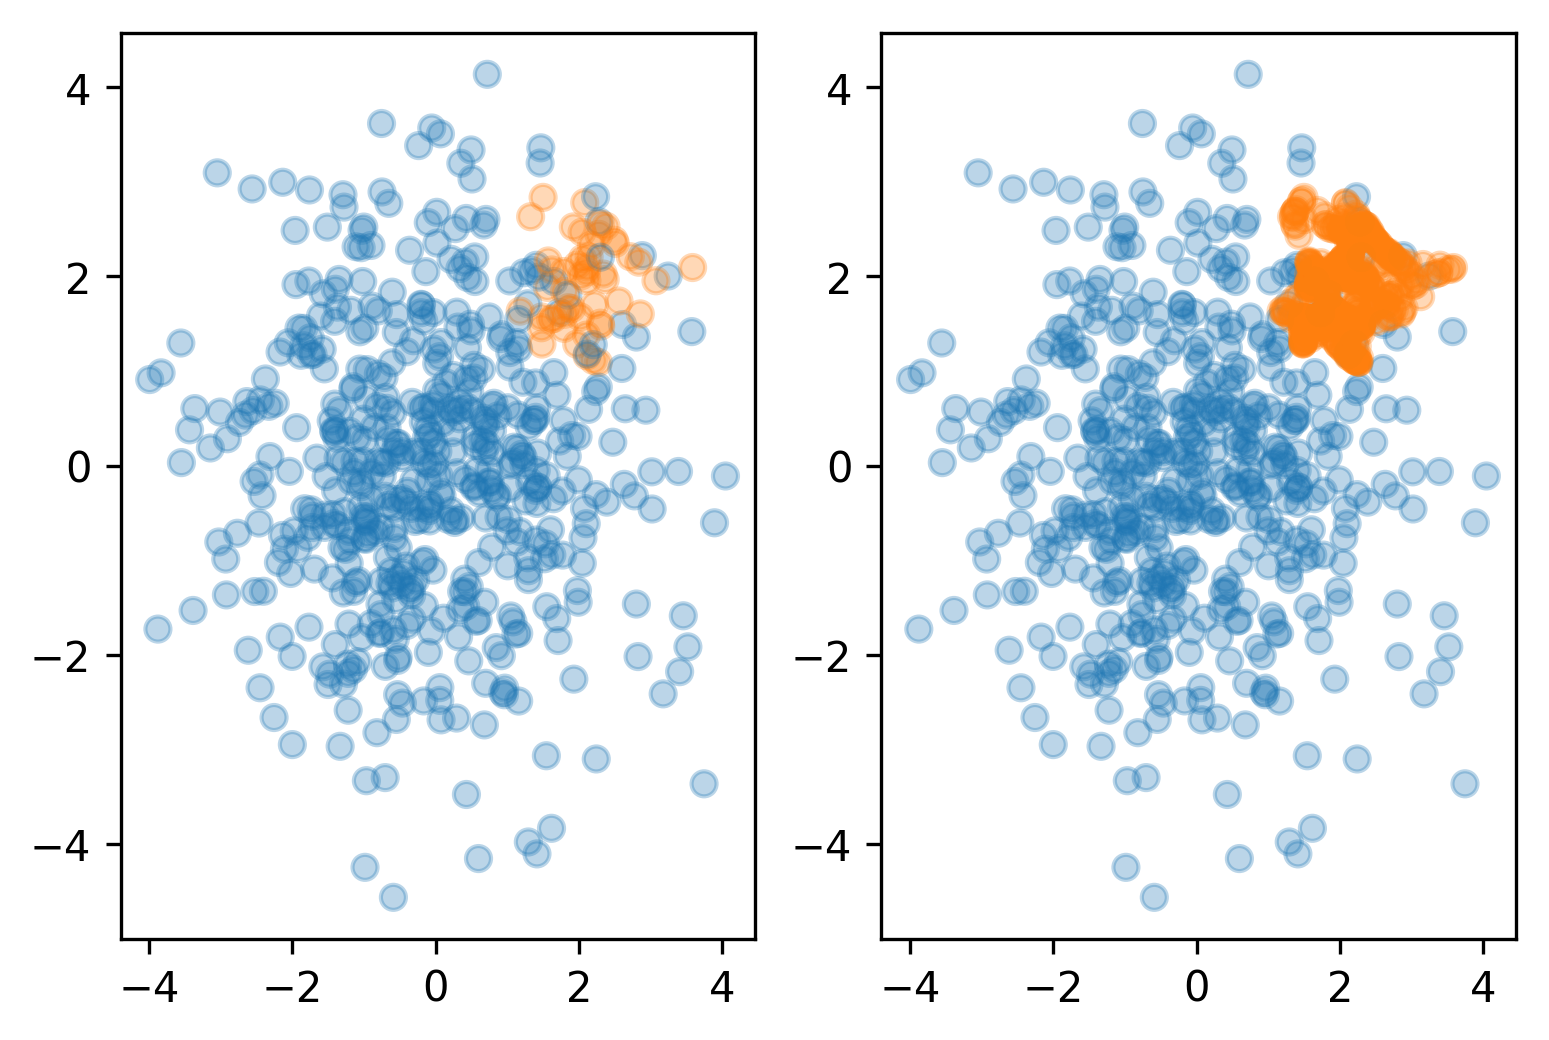

In [298]:
X_resampled, y_resampled = SMOTE().fit_sample(X_syn, y_syn)
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_syn[:, 0], X_syn[:, 1], c=plt.cm.Vega10(y_syn), alpha=.3)
axes[1].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.Vega10(y_resampled), alpha=.3)

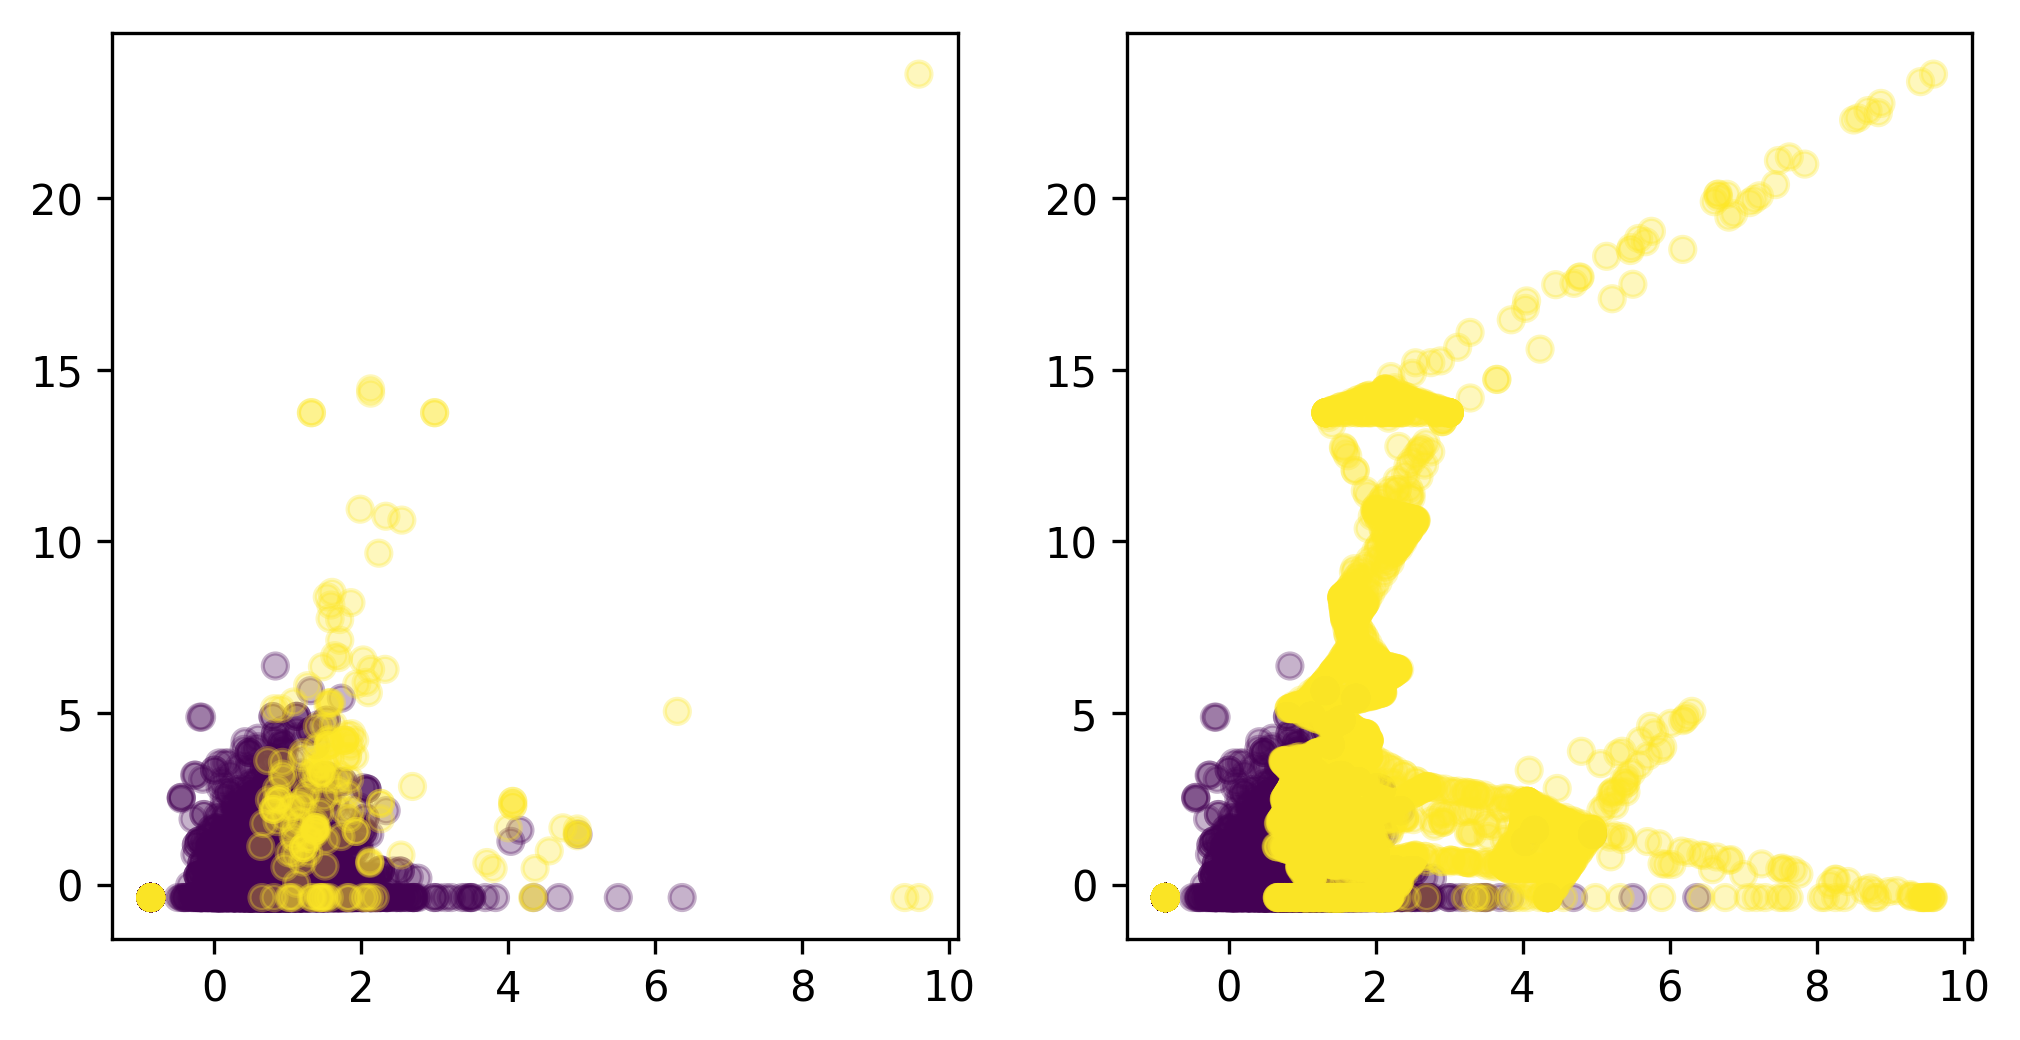

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sorting = np.argsort(y_train)
axes[0].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[1].scatter(X_train_smote[:, 3], X_train_smote[:, 4], c=y_train_smote, alpha=.3)

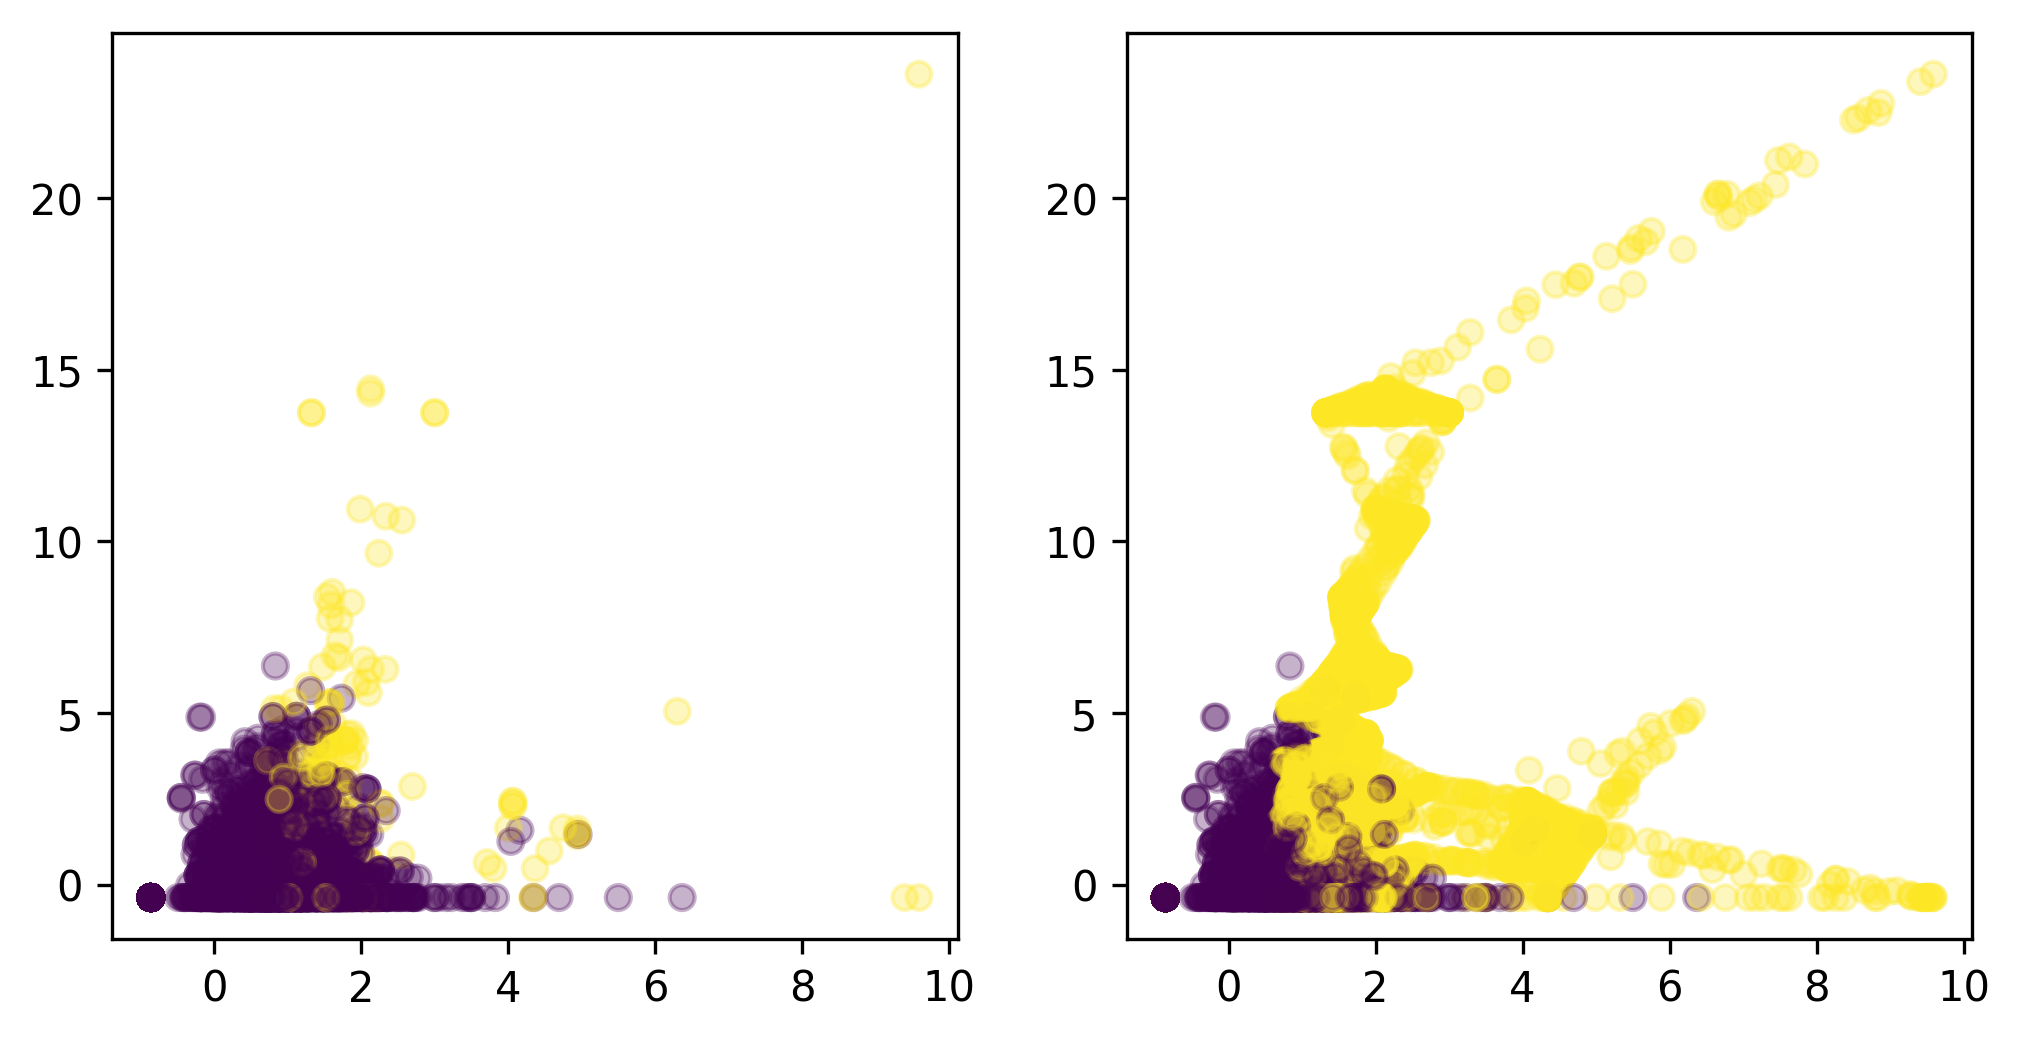

In [223]:
from sklearn.utils import shuffle
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_sh, y_smote_sh = shuffle(X_train_smote, y_train_smote)
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train, alpha=.3)
axes[1].scatter(X_smote_sh[:, 3], X_smote_sh[:, 4], c=y_smote_sh, alpha=.3)

In [148]:
smote_pipe = make_imb_pipeline(SMOTE(), LogisticRegression())
scores = cross_val_score(smote_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.918776908461


In [212]:
smote_pipe_rf = make_imb_pipeline(SMOTE(), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(smote_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.94679634593


In [207]:
param_grid = {'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]}
search = GridSearchCV(smote_pipe_rf, param_grid, cv=10, scoring="roc_auc")
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, m...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [208]:
search.best_score_

0.95823089499095737

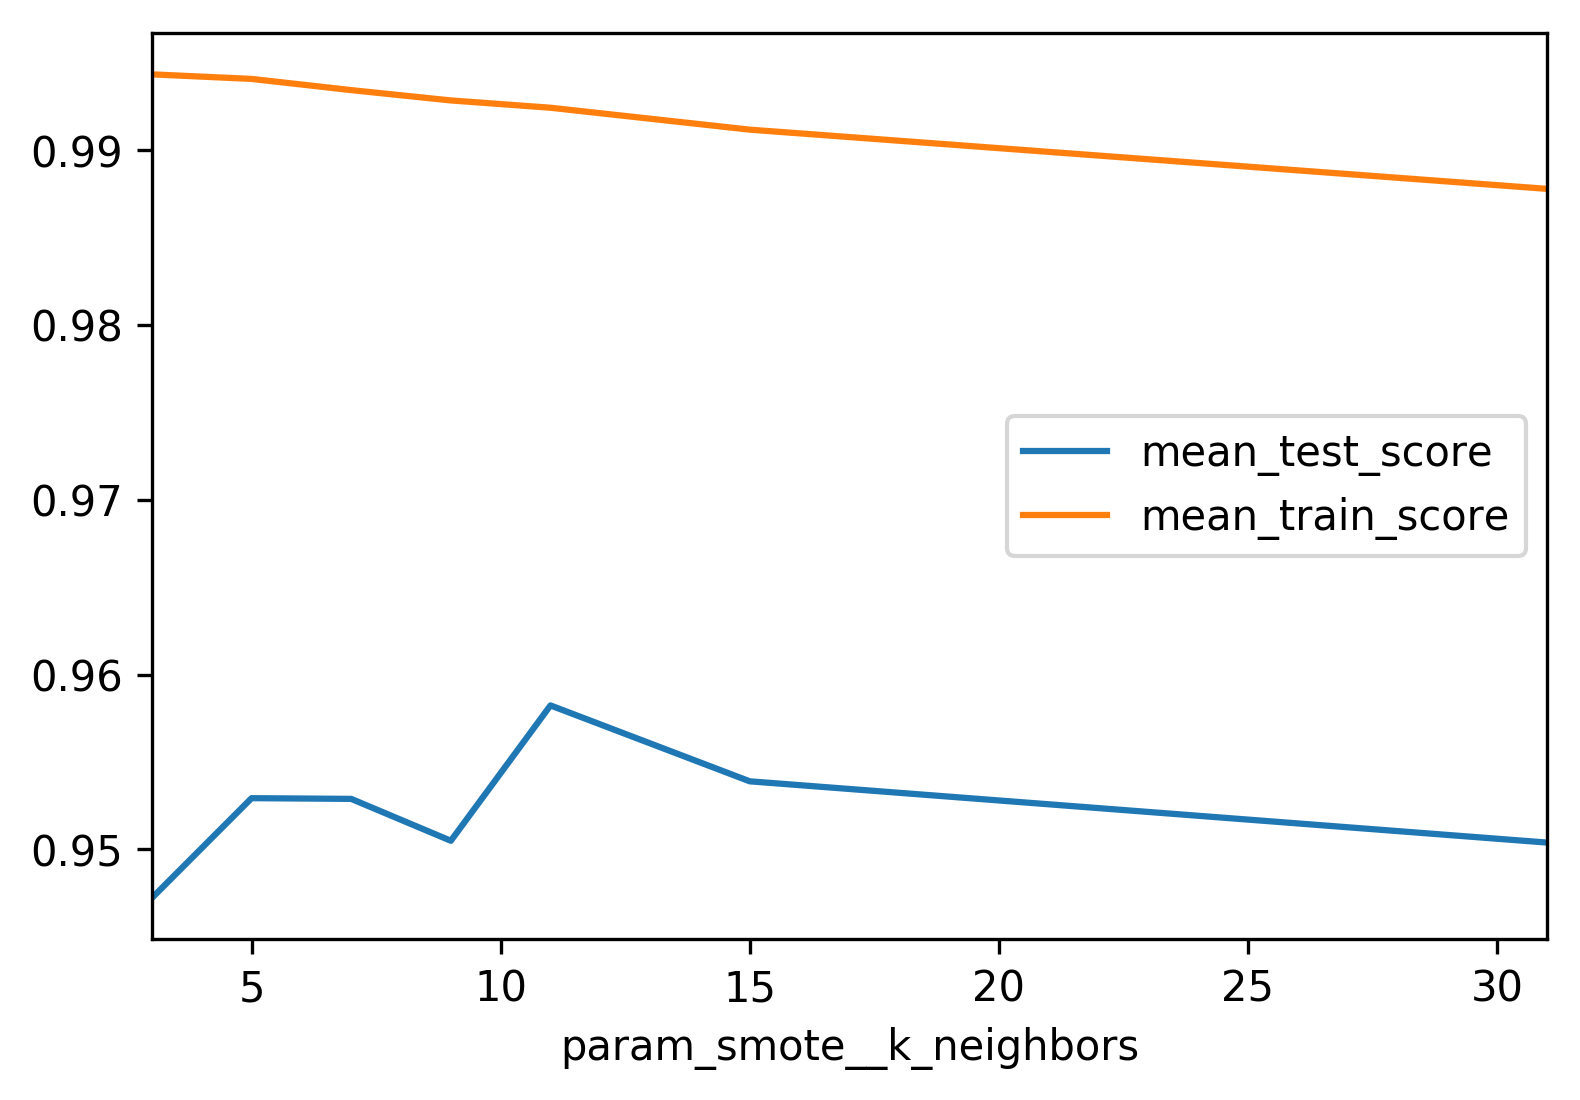

In [209]:
results = pd.DataFrame(search.cv_results_)
results.plot("param_smote__k_neighbors", ["mean_test_score", "mean_train_score"])

In [211]:
smote_pipe_rf = make_imb_pipeline(SMOTE(k_neighbors=11), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(smote_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.956115242962


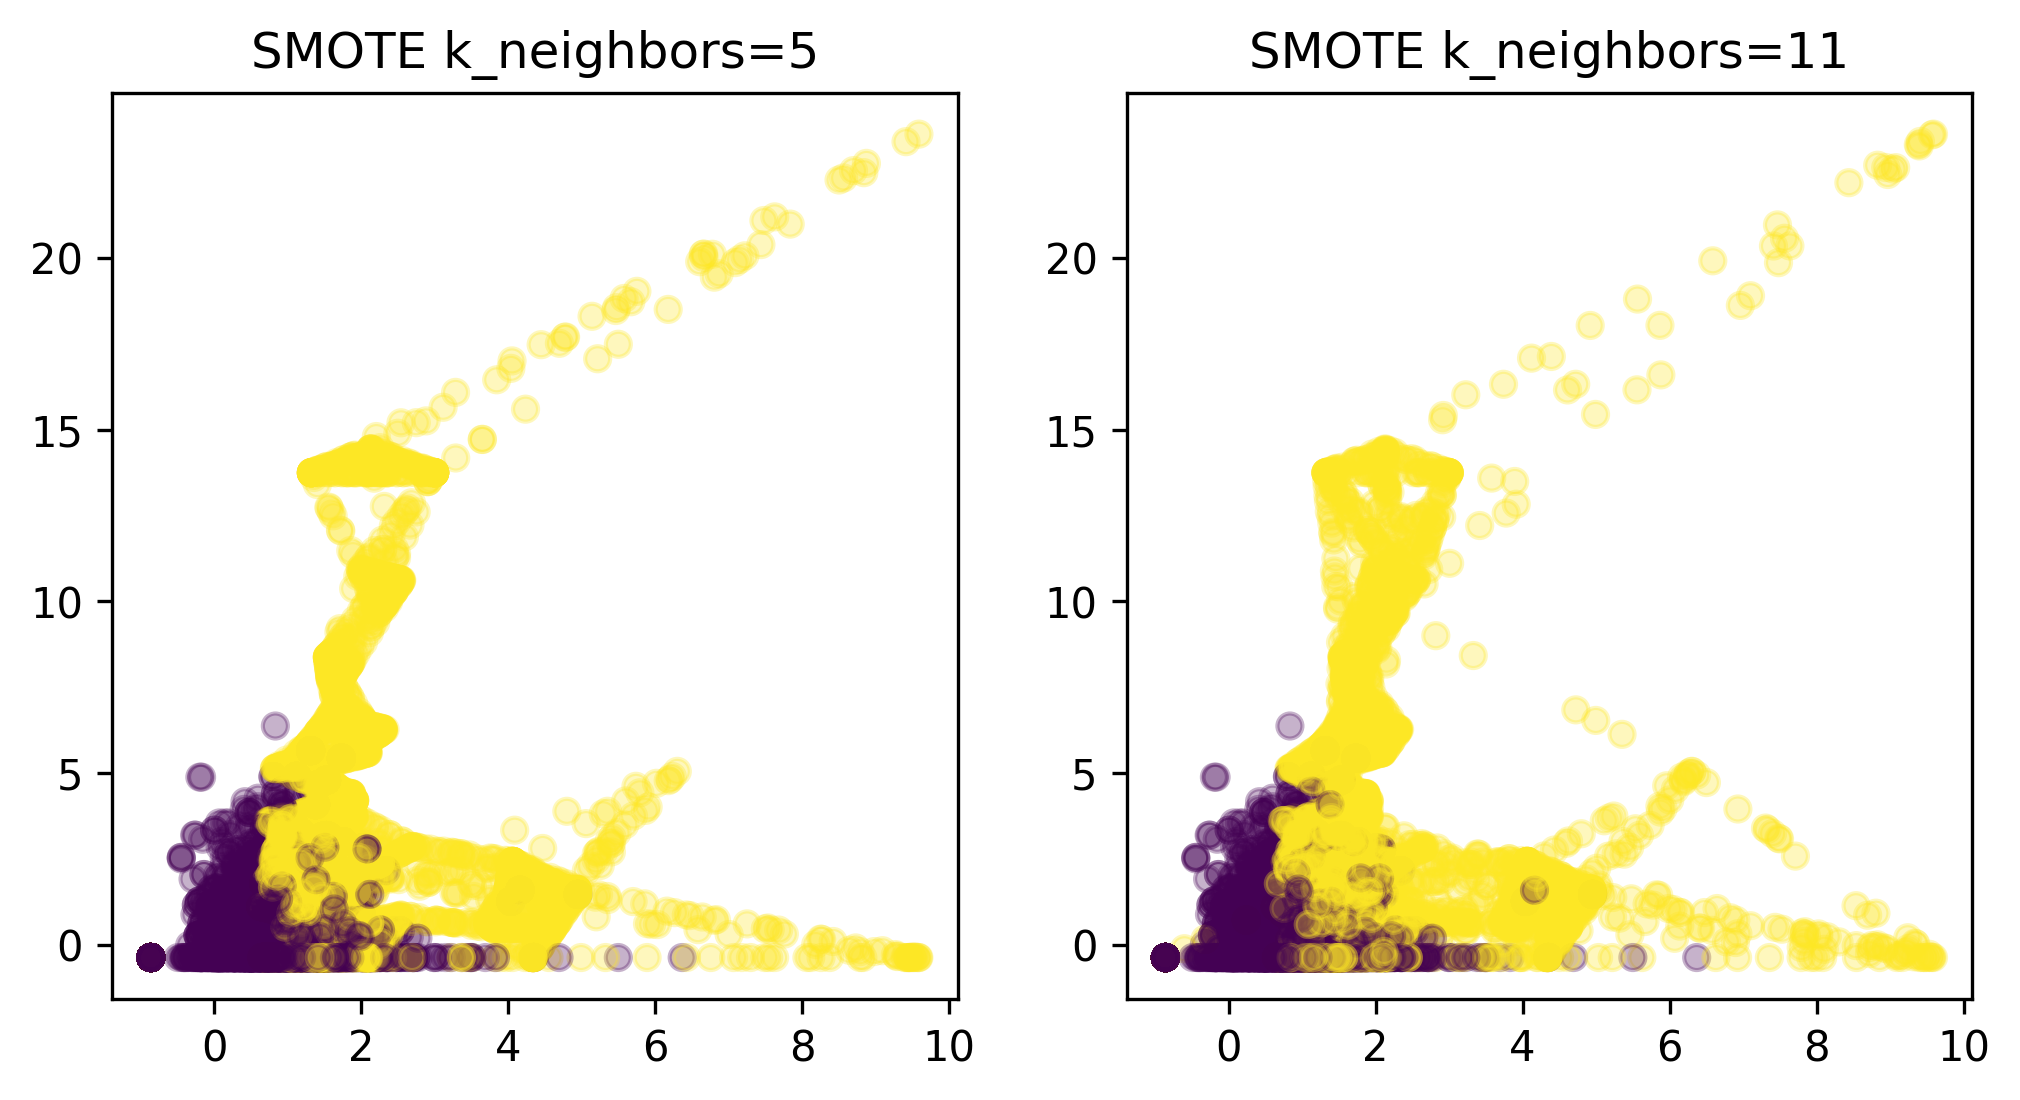

In [224]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=11)
X_train_smote11, y_train_smote11 = smote.fit_sample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_sh11, y_smote_sh11 = shuffle(X_train_smote11, y_train_smote11)
axes[0].scatter(X_smote_sh[:, 3], X_smote_sh[:, 4], c=y_smote_sh, alpha=.3)
axes[1].scatter(X_smote_sh11[:, 3], X_smote_sh11[:, 4], c=y_smote_sh11, alpha=.3)
axes[0].set_title("SMOTE k_neighbors=5")
axes[1].set_title("SMOTE k_neighbors=11")

In [214]:
from imblearn.combine import SMOTEENN, SMOTETomek
smoteenn_pipe_rf = make_imb_pipeline(SMOTEENN(smote=SMOTE(k_neighbors=11)), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(smoteenn_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.953204388982


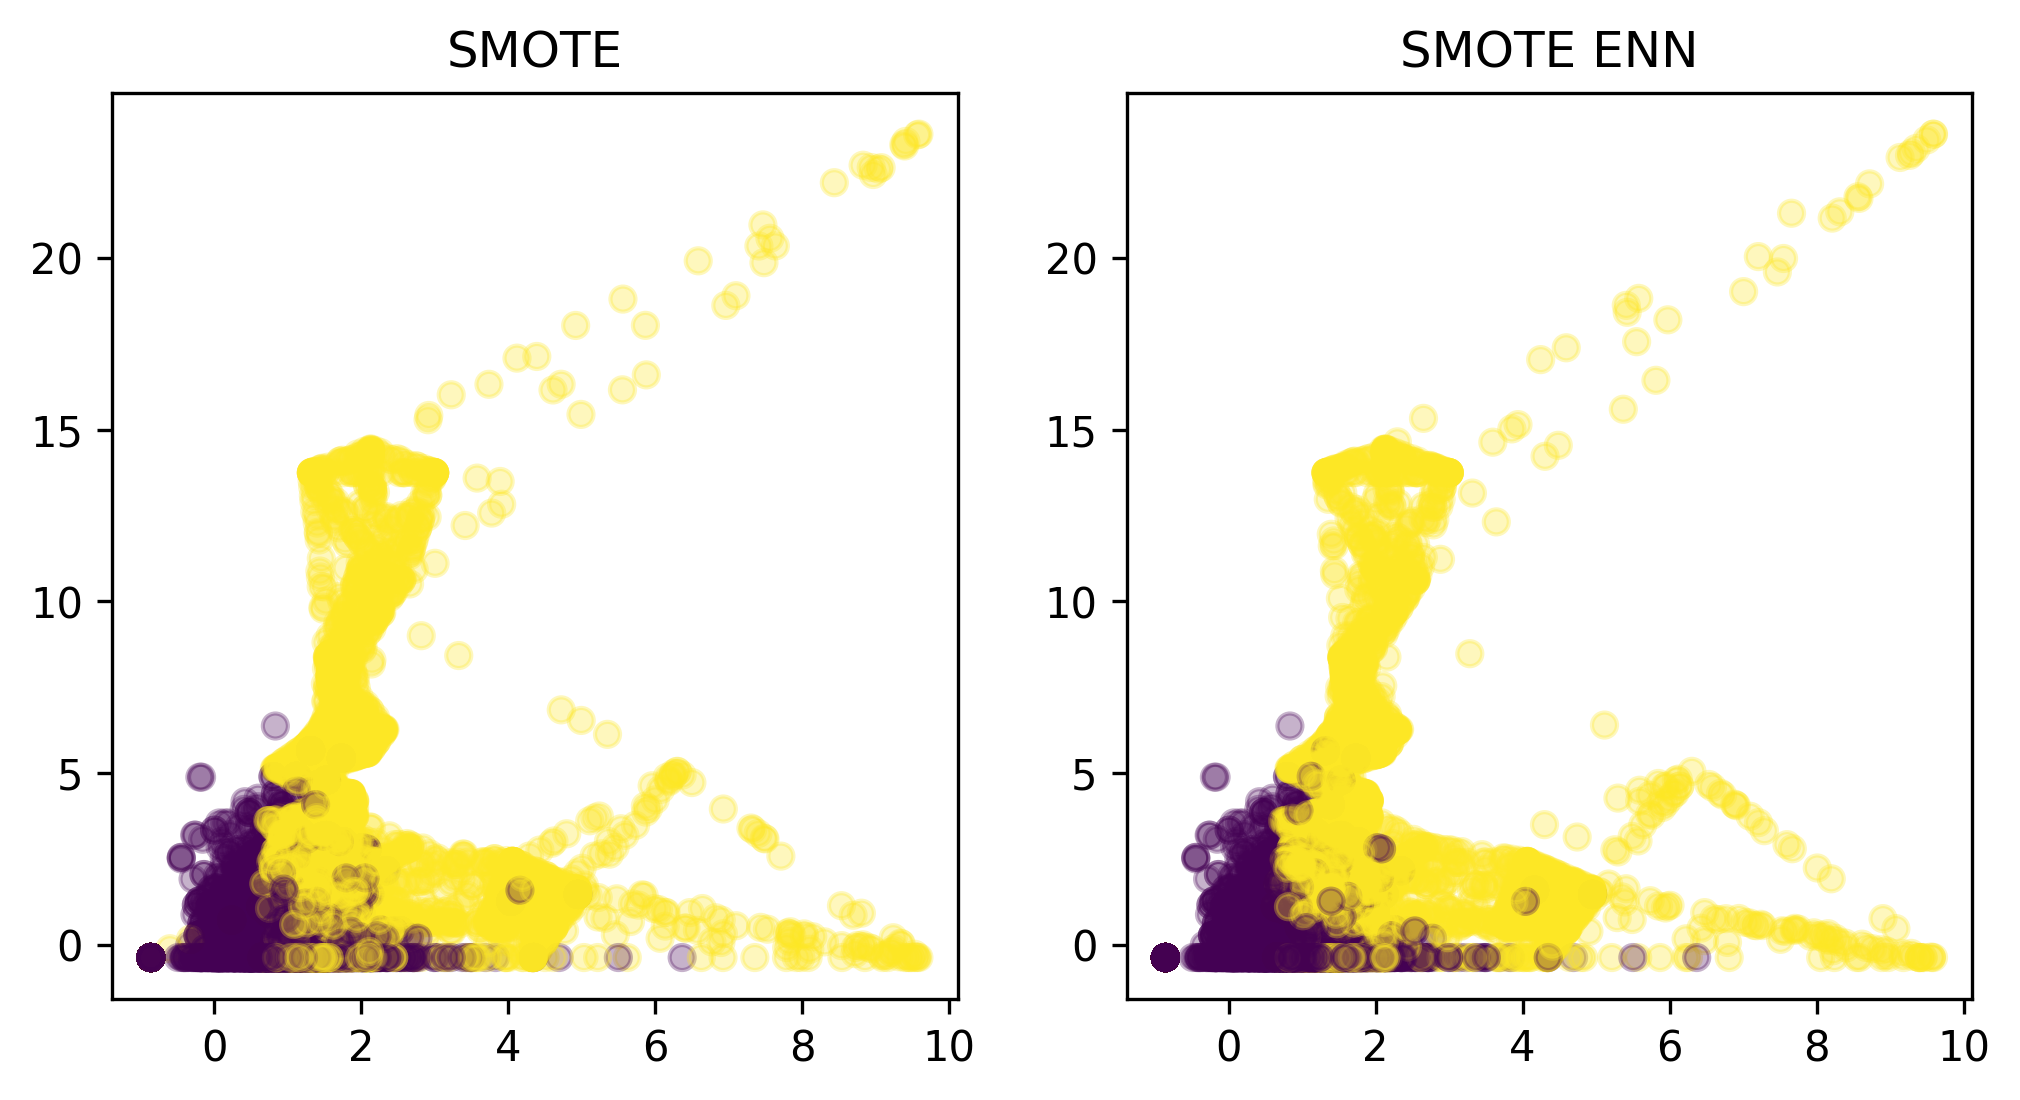

In [299]:
smoteenn = SMOTEENN(smote=SMOTE(k_neighbors=11))

X_train_smoteenn, y_train_smoteenn = smoteenn.fit_sample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_shenn, y_smote_shenn = shuffle(X_train_smoteenn, y_train_smoteenn)
axes[0].scatter(X_smote_sh11[:, 3], X_smote_sh11[:, 4], c=y_smote_sh11, alpha=.3)
axes[1].scatter(X_smote_shenn[:, 3], X_smote_shenn[:, 4], c=y_smote_shenn, alpha=.3)
axes[0].set_title("SMOTE")
axes[1].set_title("SMOTE ENN")

In [231]:
np.bincount(y_train_smote11)

array([8192, 8192])

In [230]:
np.bincount(y_train_smoteenn)

array([8192, 7755])

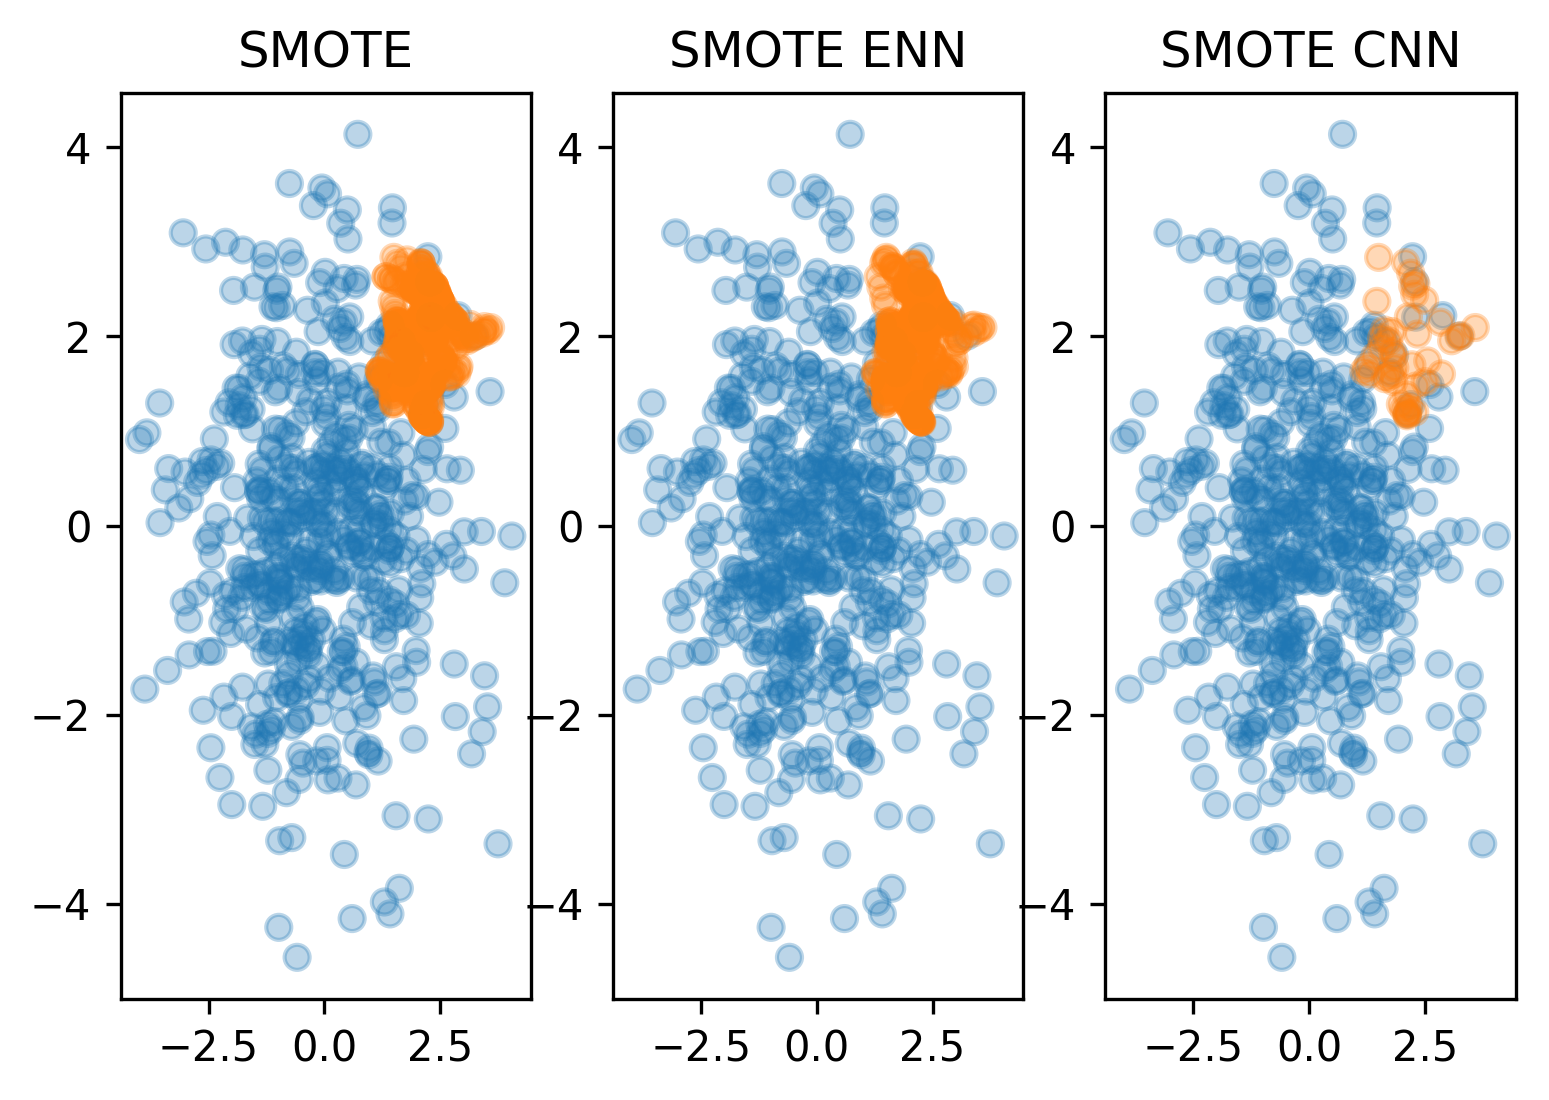

In [305]:
X_resampled, y_resampled = SMOTE().fit_sample(X_syn, y_syn)
X_resampled_enn, y_resampled_enn = SMOTEENN().fit_sample(X_syn, y_syn)
X_resampled_cnn, y_resampled_cnn = make_imb_pipeline(SMOTE(), CondensedNearestNeighbour()).fit_sample(X_syn, y_syn)

fig, axes = plt.subplots(1, 3)

axes[0].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.Vega10(y_resampled), alpha=.3)
axes[0].set_title("SMOTE")
axes[1].scatter(X_resampled_enn[:, 0], X_resampled_enn[:, 1], c=plt.cm.Vega10(y_resampled_enn), alpha=.3)
axes[1].set_title("SMOTE ENN")
axes[2].scatter(X_resampled_cnn[:, 0], X_resampled_cnn[:, 1], c=plt.cm.Vega10(y_resampled_cnn), alpha=.3)
axes[2].set_title("SMOTE CNN")